<font size="20">Predicting Stock Market Trends Using Predictive Analytics, SARIMA Analysis</font>

Author: Yagnesh Rajani

<font size="20" color = "Blue">Libraries, Packages and Data Setup</font>

Install and Import Libraries and Packages

In [1]:
#%pip install matplotlib
#%pip install pandas
#%pip install pmdarima
#%pip install scikit-learn

import sklearn.metrics as metrics
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pmdarima.arima.utils import nsdiffs
import sklearn.base
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

Import Datasets

In [2]:
raw_dataset = pd.DataFrame(pd.read_csv("dataset.csv", sep = ",", header = 0, parse_dates=['Date']))

Format Date to fit Modeling Requirements

In [3]:
attribute_list = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
dataset = raw_dataset[attribute_list]
date = raw_dataset['Date']
date = date.astype('string')
date = date.str[:-15]
dataset.insert(0, "Date", date)
dataset.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02,0.058398,0.060358,0.058398,0.058398,841958,0.0,0.0
1,1962-01-03,0.058398,0.059378,0.058398,0.059182,801865,0.0,0.0
2,1962-01-04,0.059182,0.059378,0.058791,0.059182,962238,0.0,0.0
3,1962-01-05,0.059182,0.059574,0.058987,0.059378,962238,0.0,0.0
4,1962-01-08,0.059378,0.060162,0.058007,0.059182,1282984,0.0,0.0


Model Evaluation Setup

In [4]:
evals = []
def evaluations(test, pred):
    mae = metrics.mean_absolute_error(test, pred)
    mape = metrics.mean_absolute_percentage_error(test, pred)
    mse = metrics.mean_squared_error(test, pred)
    rmse = mse**0.5
    #evals = {'MAE': mae, "MAPE": mape, "MSE": mse, "RMSE": rmse}
    evals = [mae, mape, mse, rmse]
    return(evals)

<font size="6" color = "Orange">Split the Data Into Training and Testing Datasets</font>

Find the Index Where the Data Will be Split

In [5]:
# Get the index where the training and test datasets will be split from
# Note that due to the abundance of data, we are using an 80% training and 20% testing split
splitval = 0.80
div_index = round(dataset.shape[0] * splitval)
split_date = dataset['Date'].iloc[div_index]
print("The index where the data will be split is: ", div_index)
print("The date where the data will be split is: ", split_date)

The index where the data will be split is:  12358
The date where the data will be split is:  2011-02-03


Split the Dataset

In [6]:
train_data = dataset[:div_index]
test_data = dataset[div_index:]

Find the Index of the First Day in 2020

In [7]:
covid_index = dataset[dataset['Date'] == "2020-01-02"].index.values
print(covid_index)

[14600]


Split the Dataset for the Covid Model

In [8]:
covid_train_data = dataset[:covid_index[0]]
covid_test_data = dataset[covid_index[0]:]

<font size="6" color = "Orange">Model Training and Testing</font>

Define Standard Variables

In [9]:
# Number of Seasons
seasonality = 4

Train And Test The Model

Open
(1, 1, 0)
(0, 0, 0, 4)


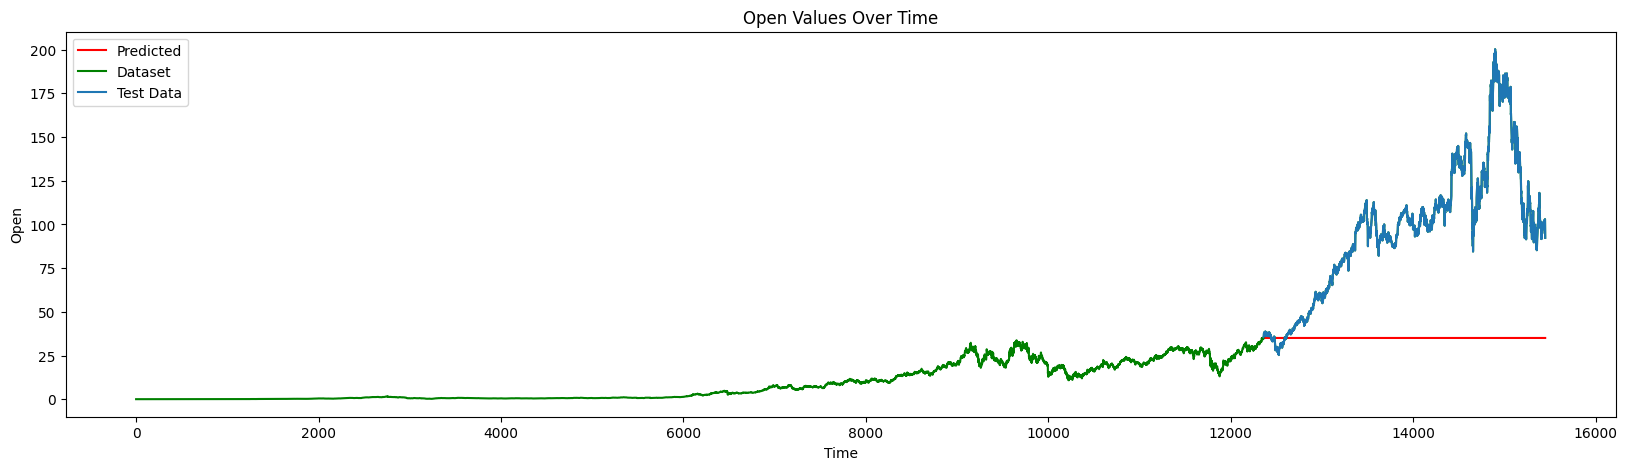

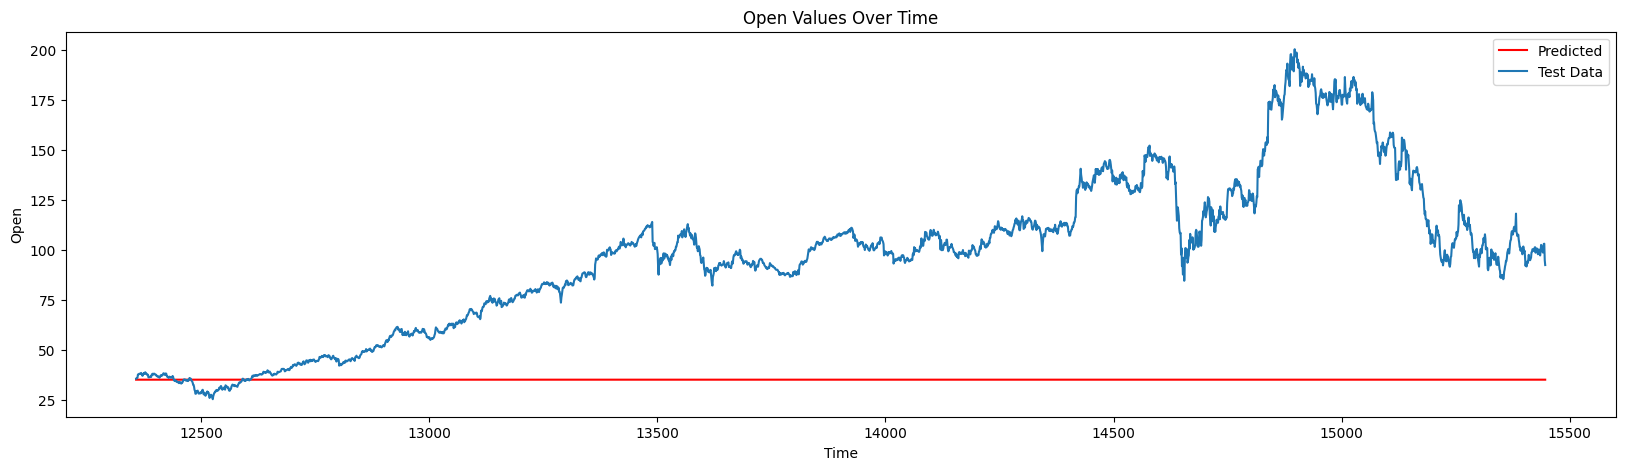

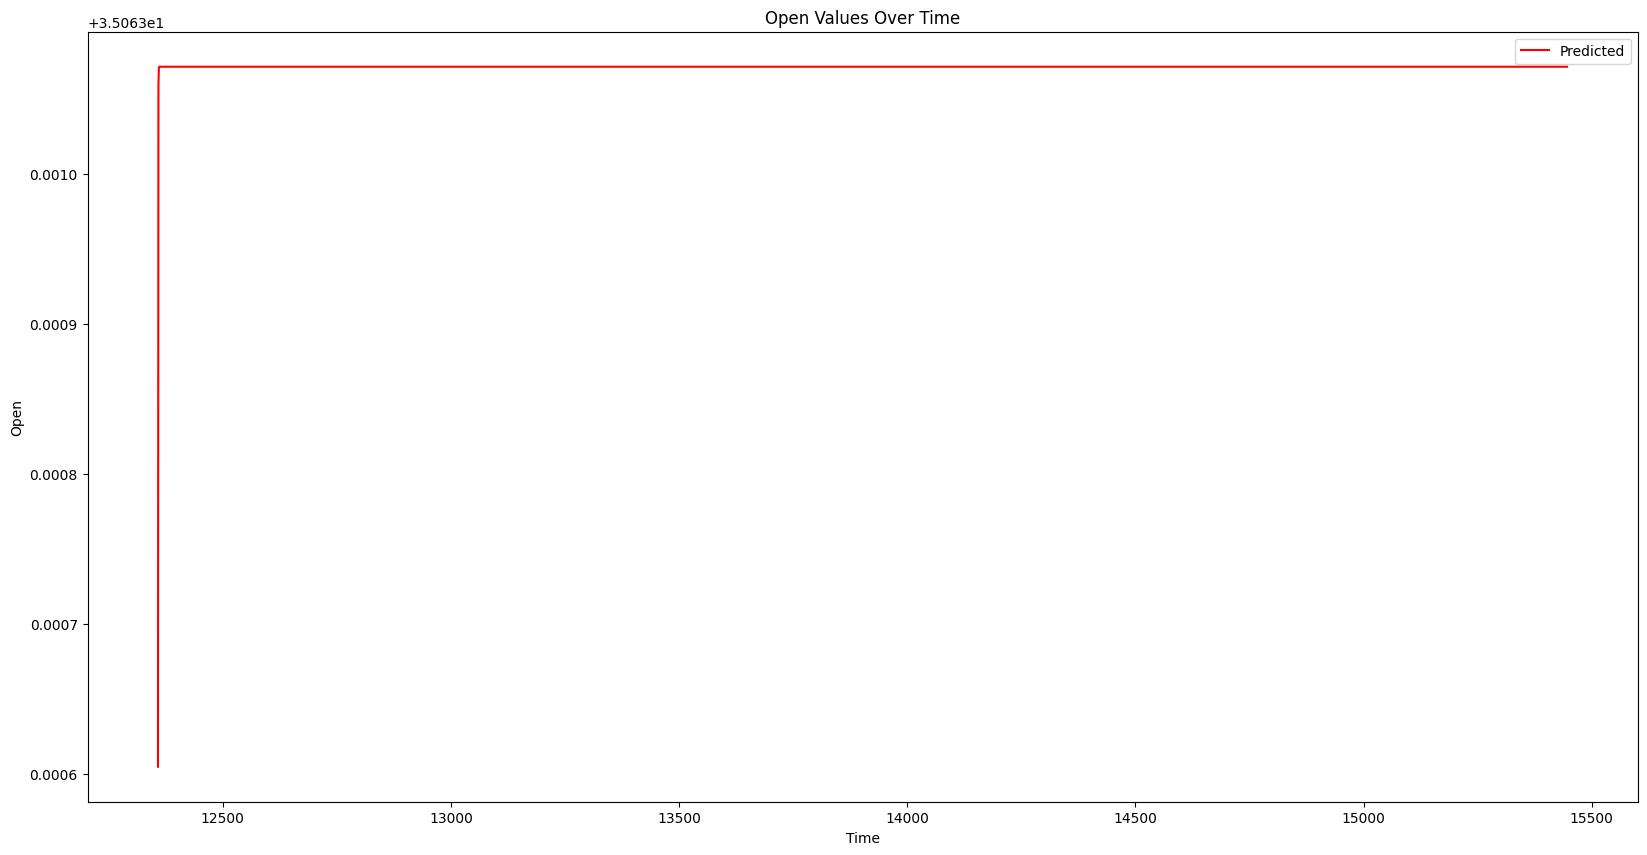

High
(2, 1, 2)
(2, 0, 2, 4)


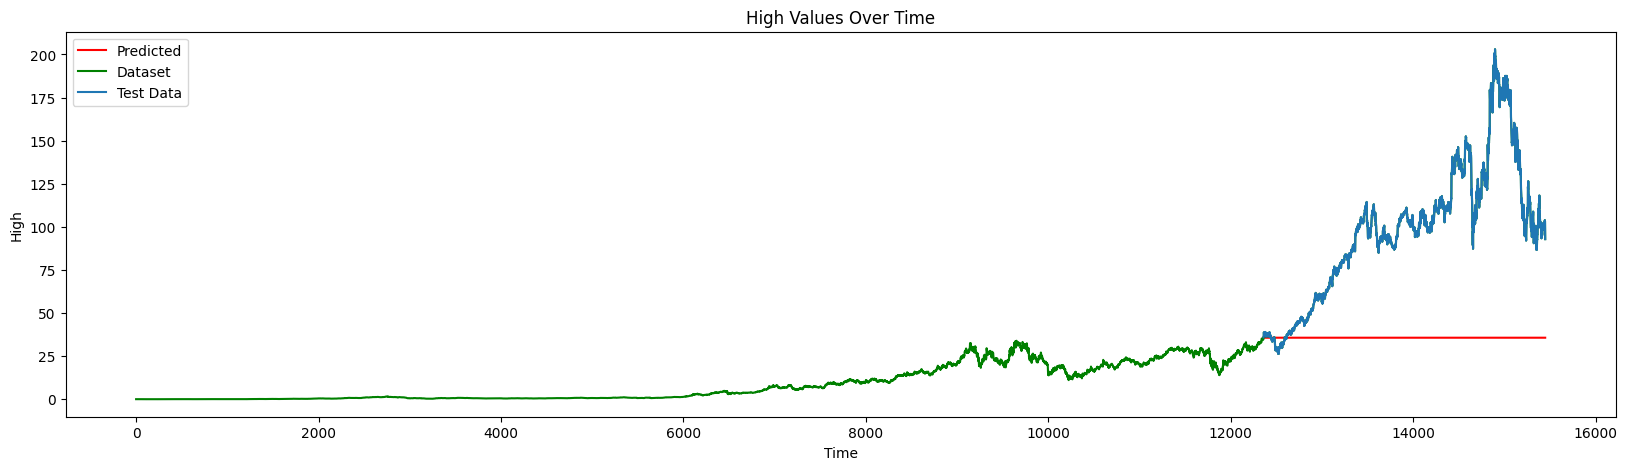

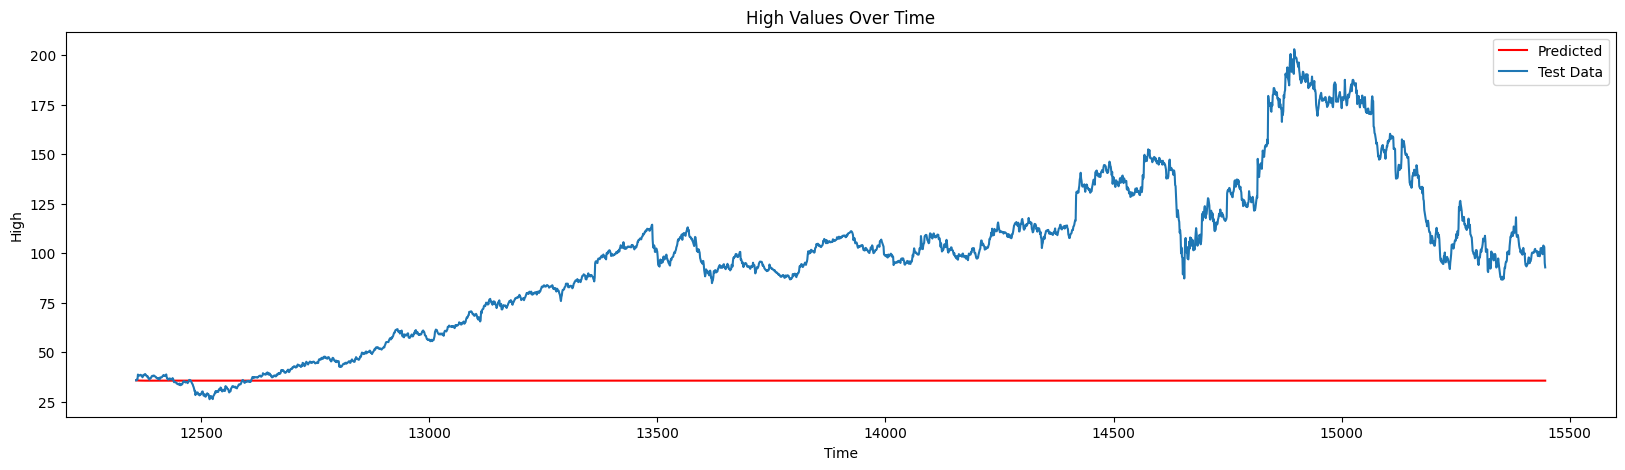

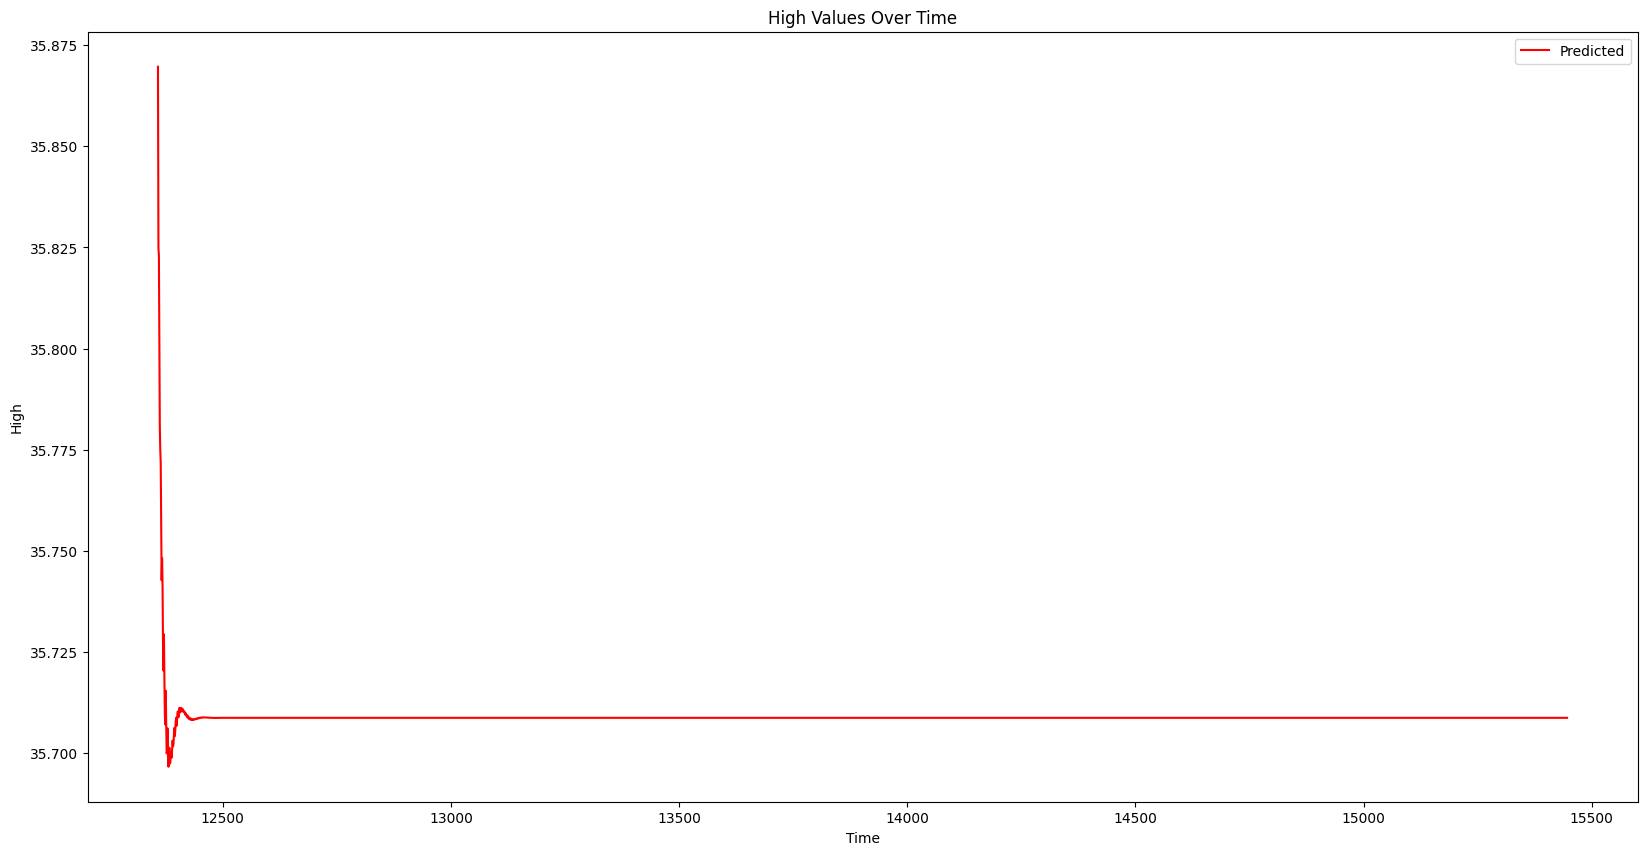

Low
(3, 1, 3)
(2, 0, 1, 4)


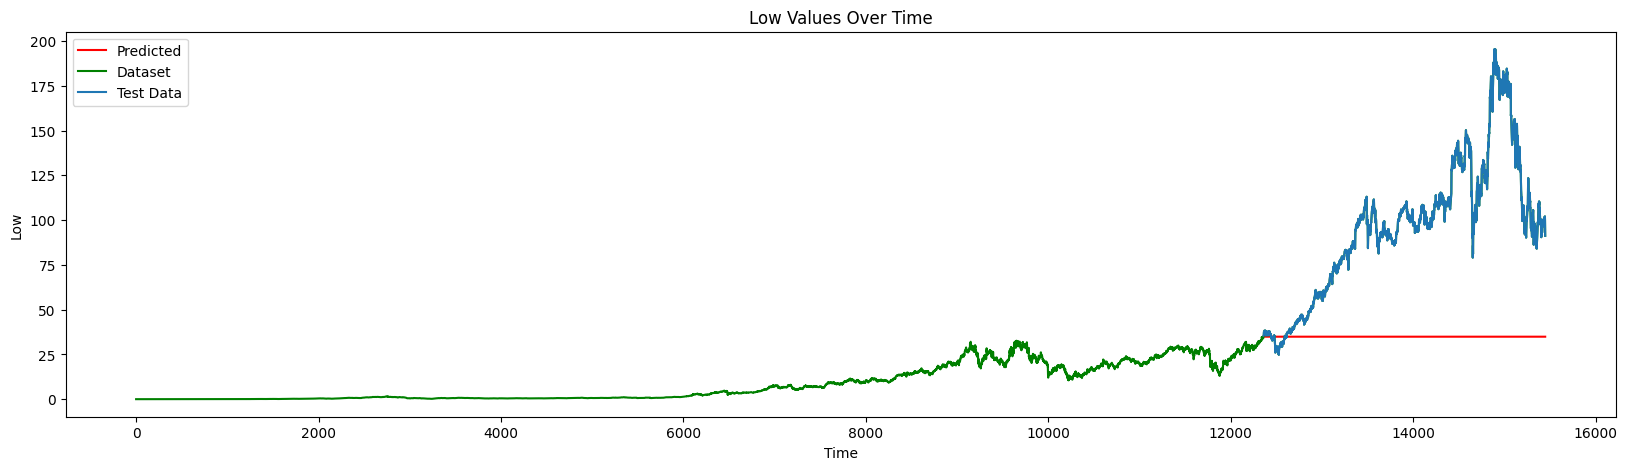

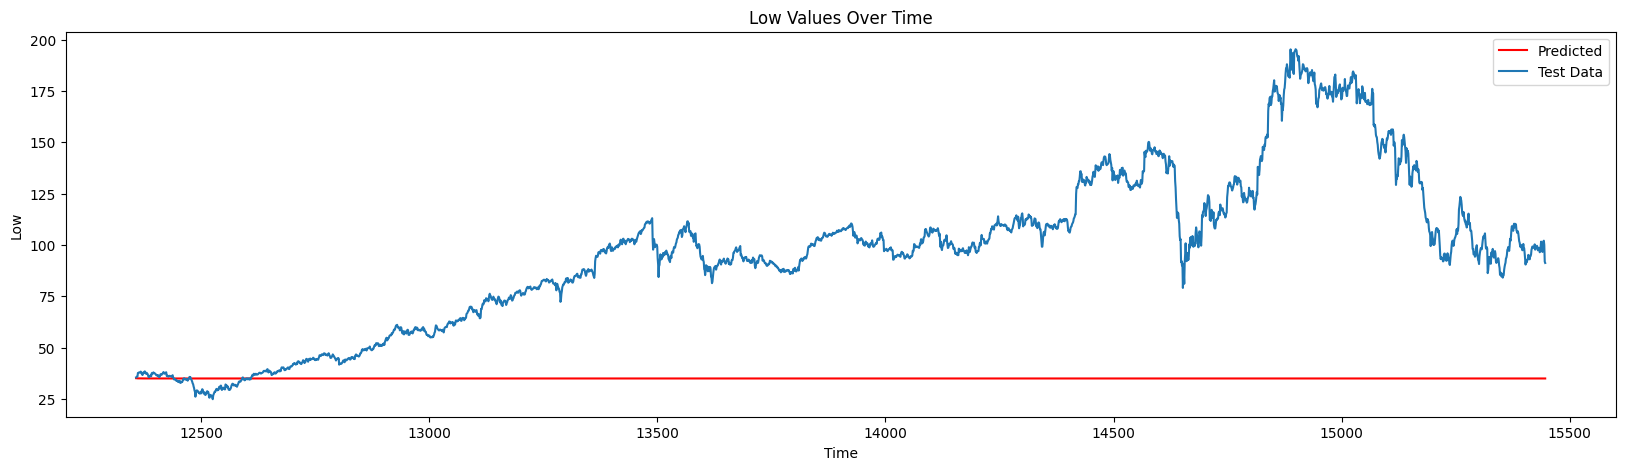

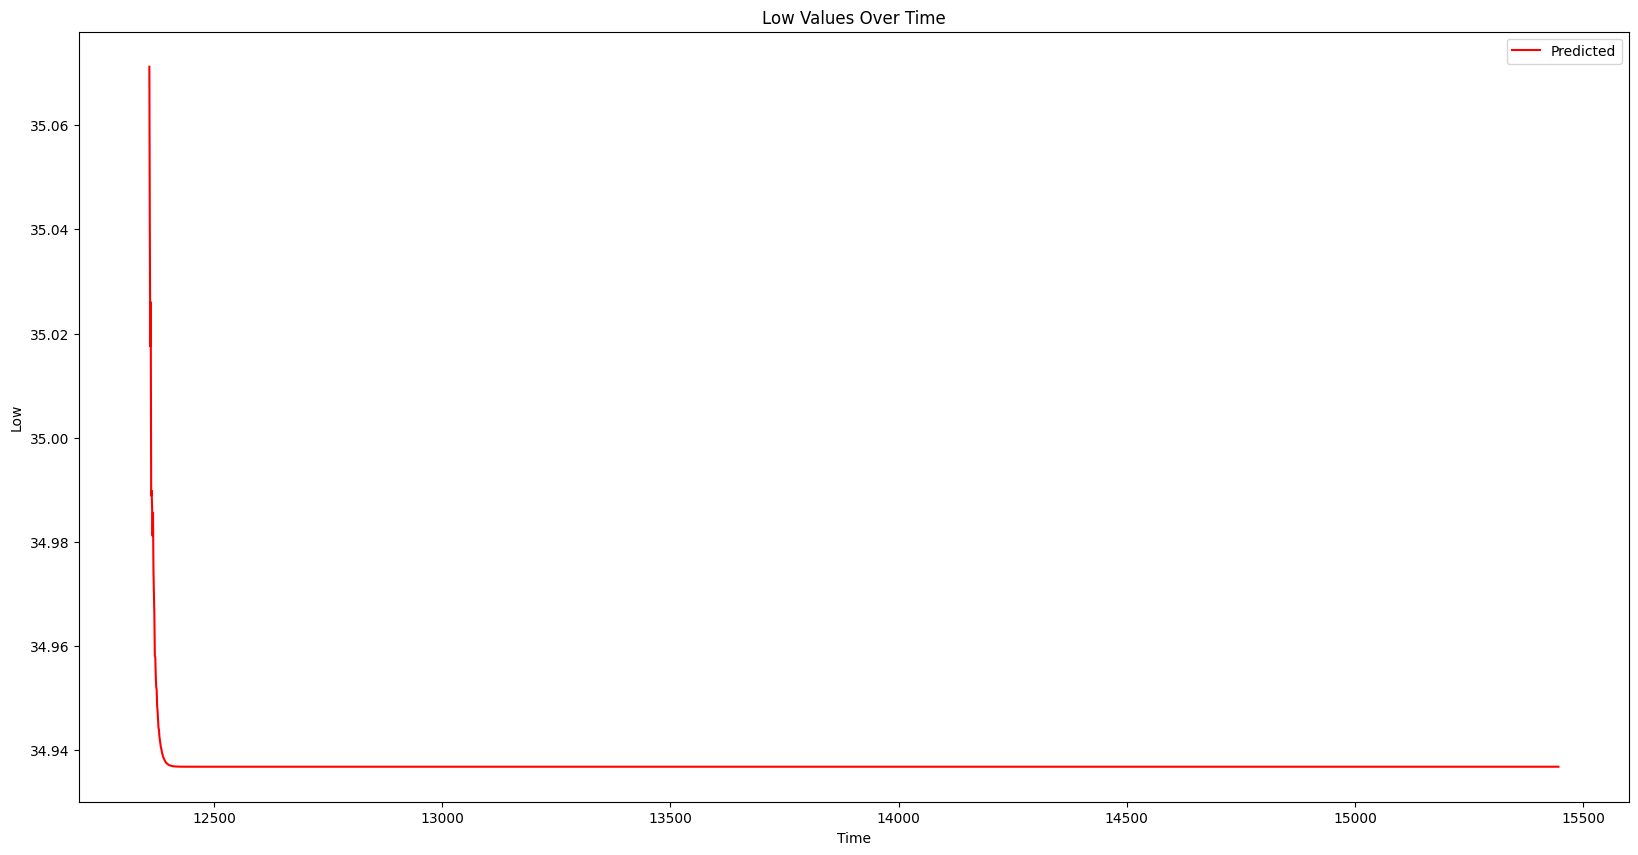

Close
(2, 1, 1)
(2, 0, 2, 4)


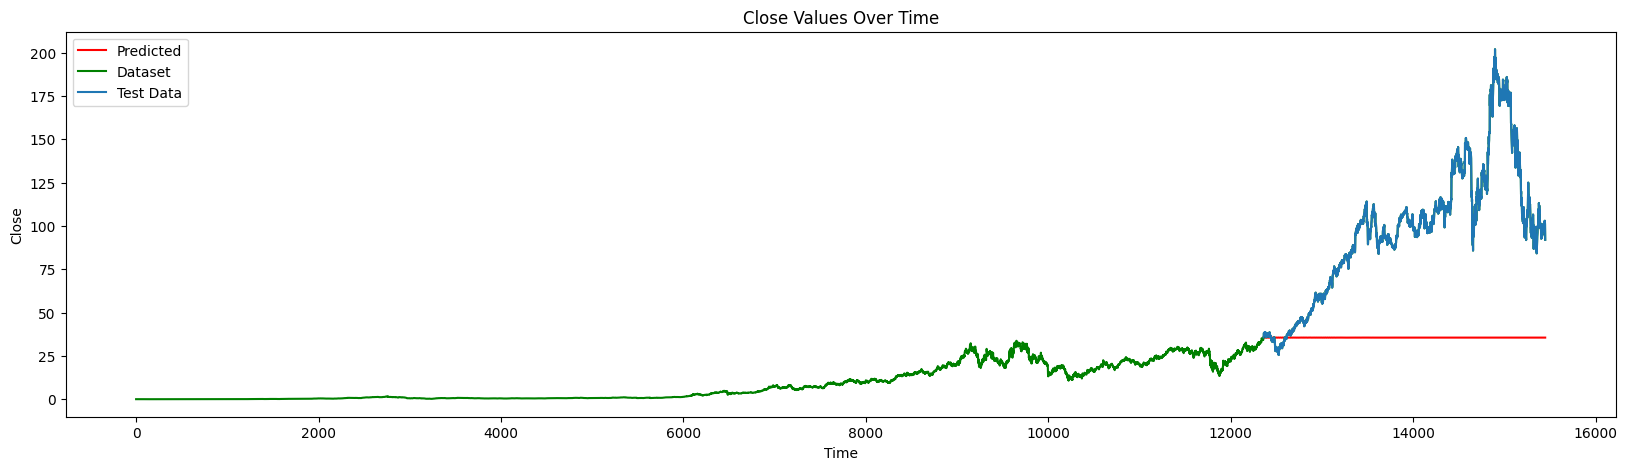

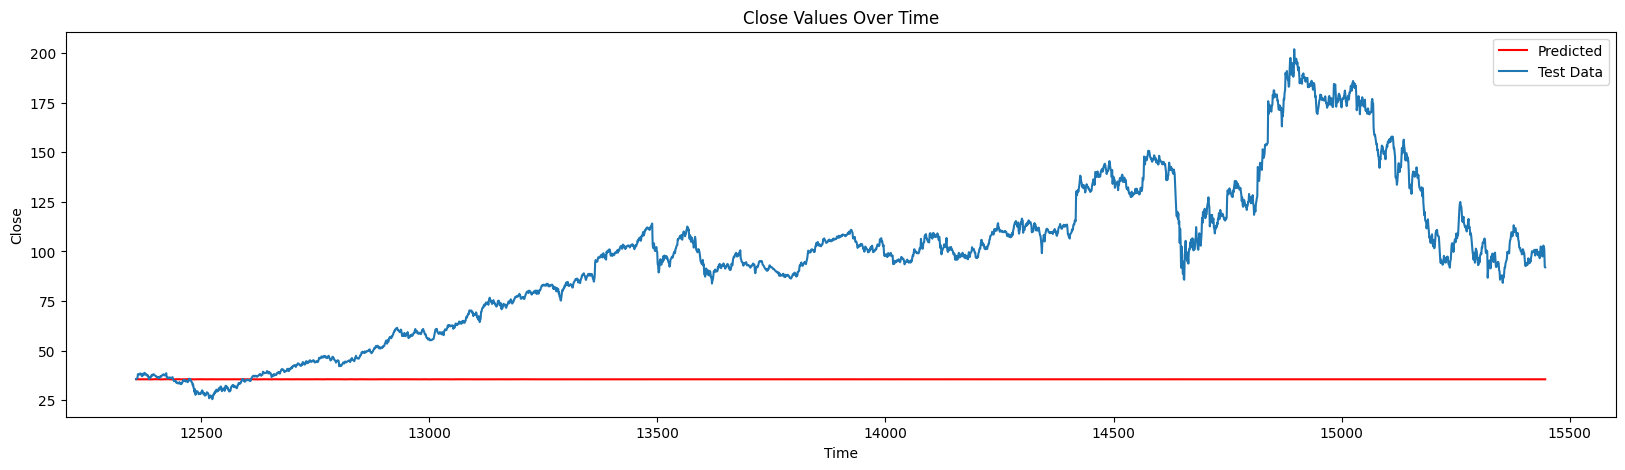

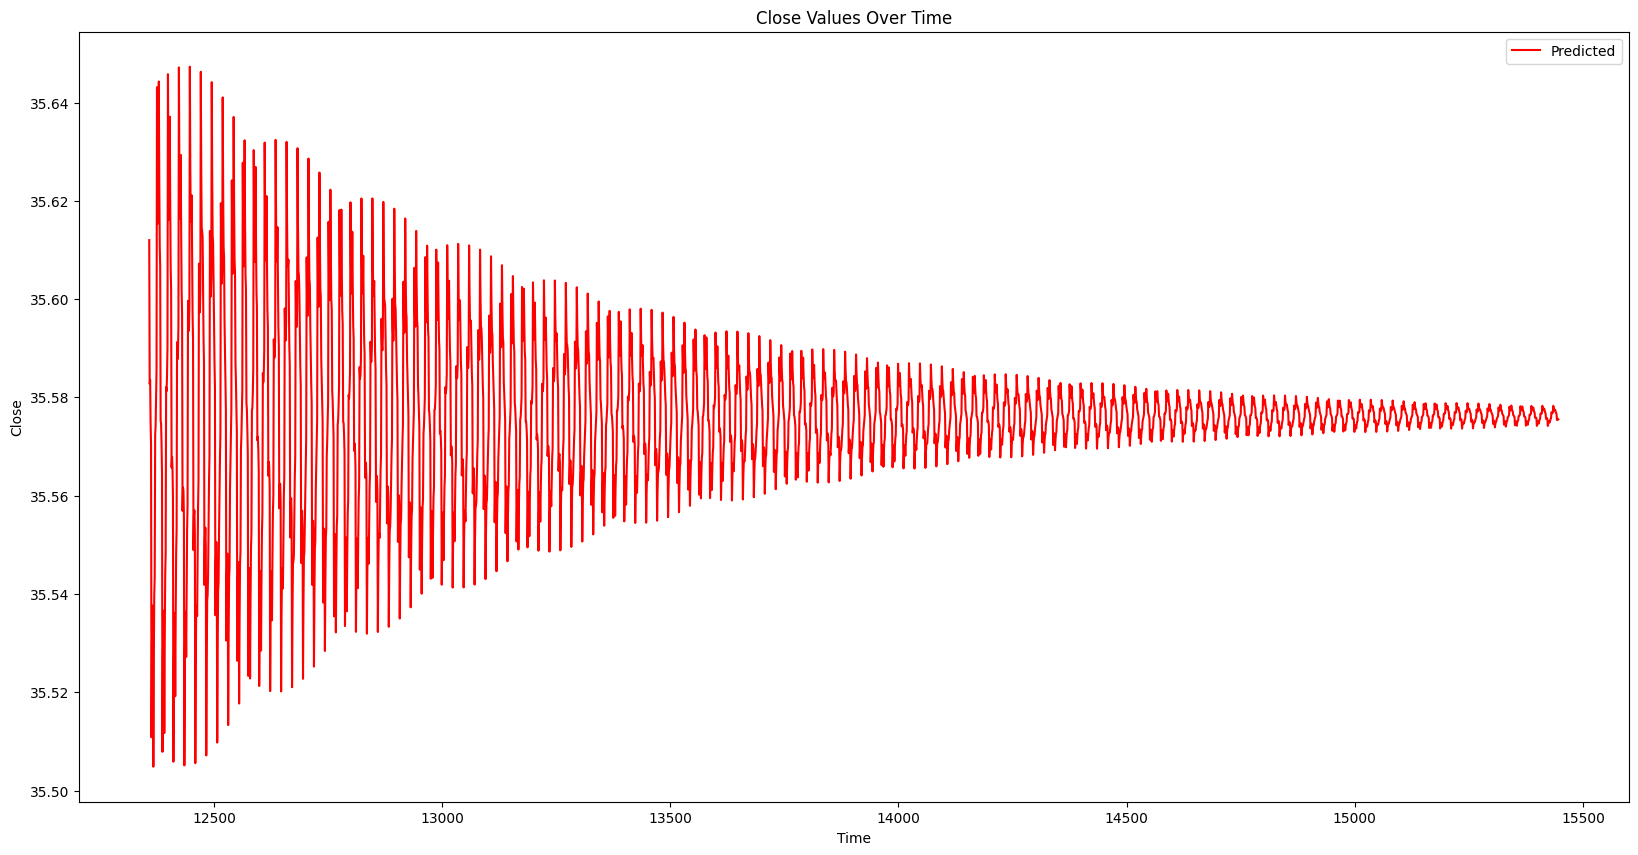

Volume
(1, 1, 3)
(2, 0, 2, 4)


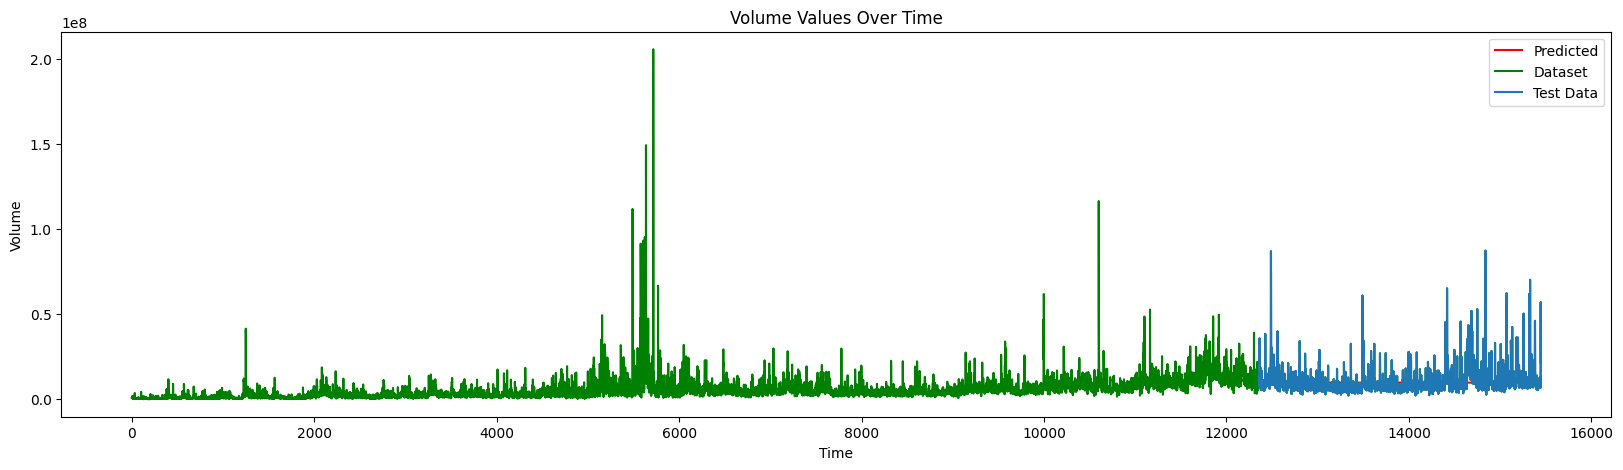

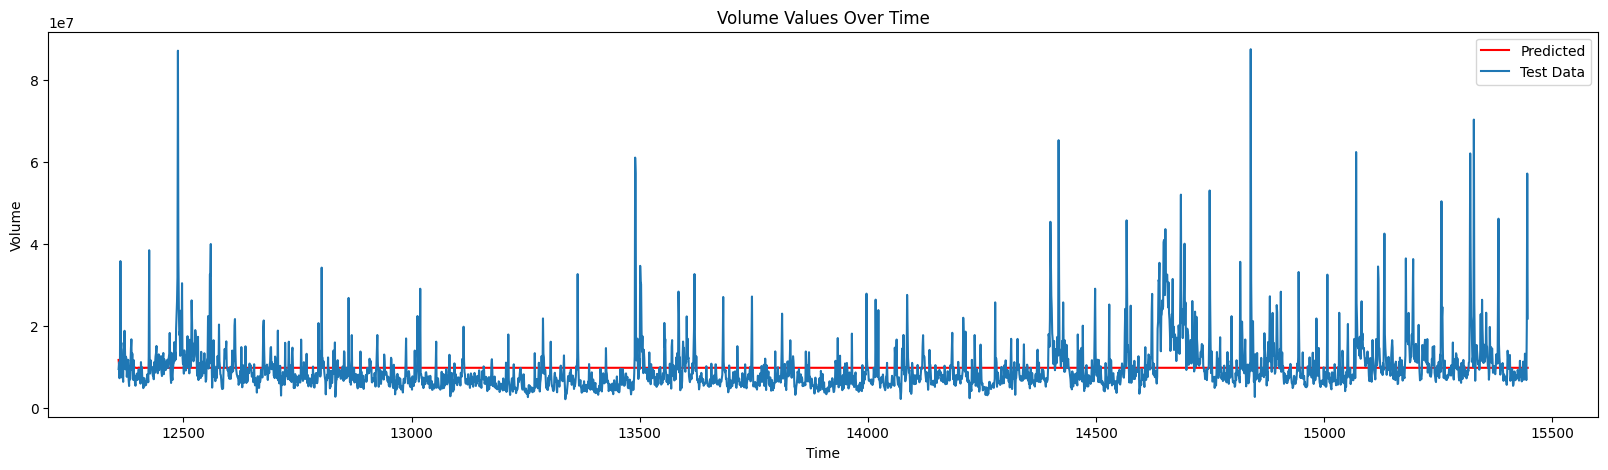

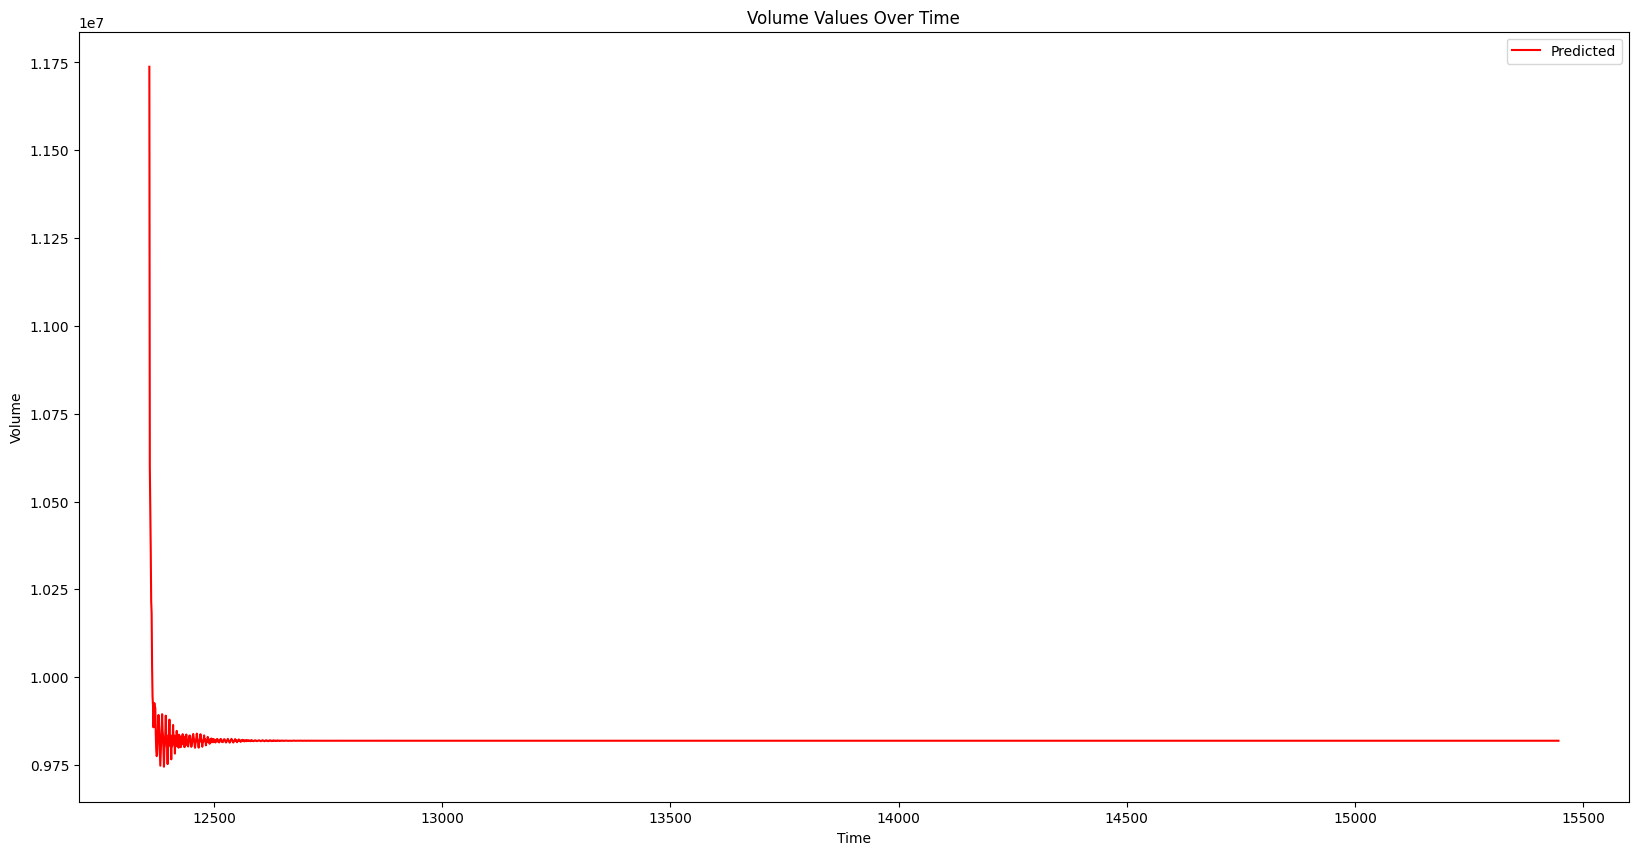

Dividends
(2, 1, 2)
(0, 0, 1, 4)


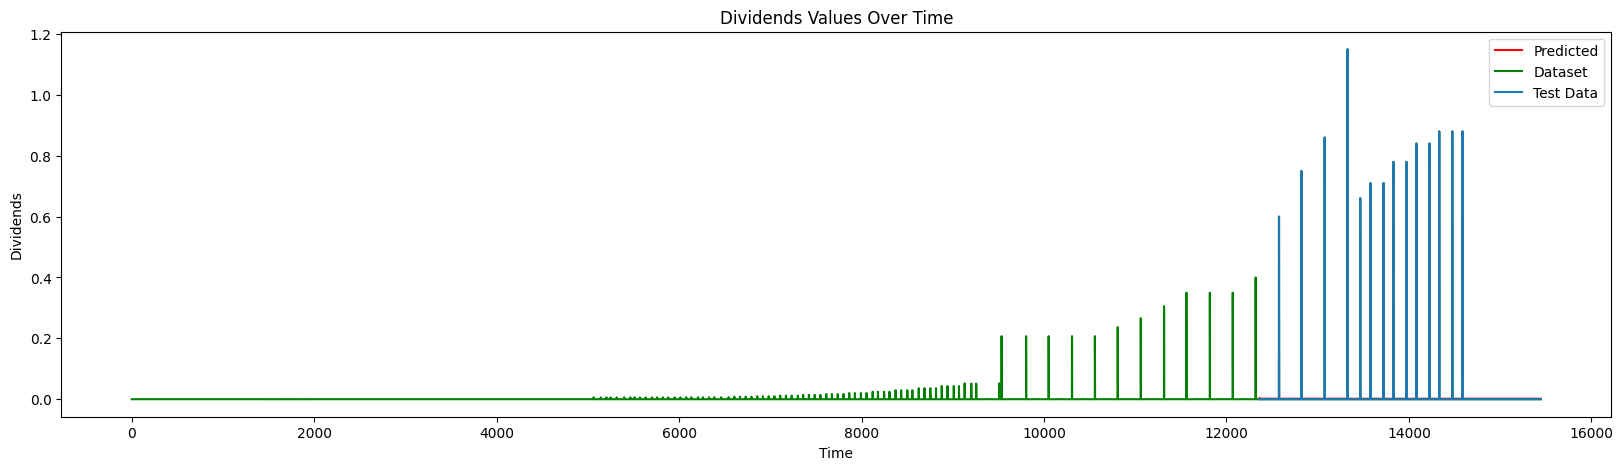

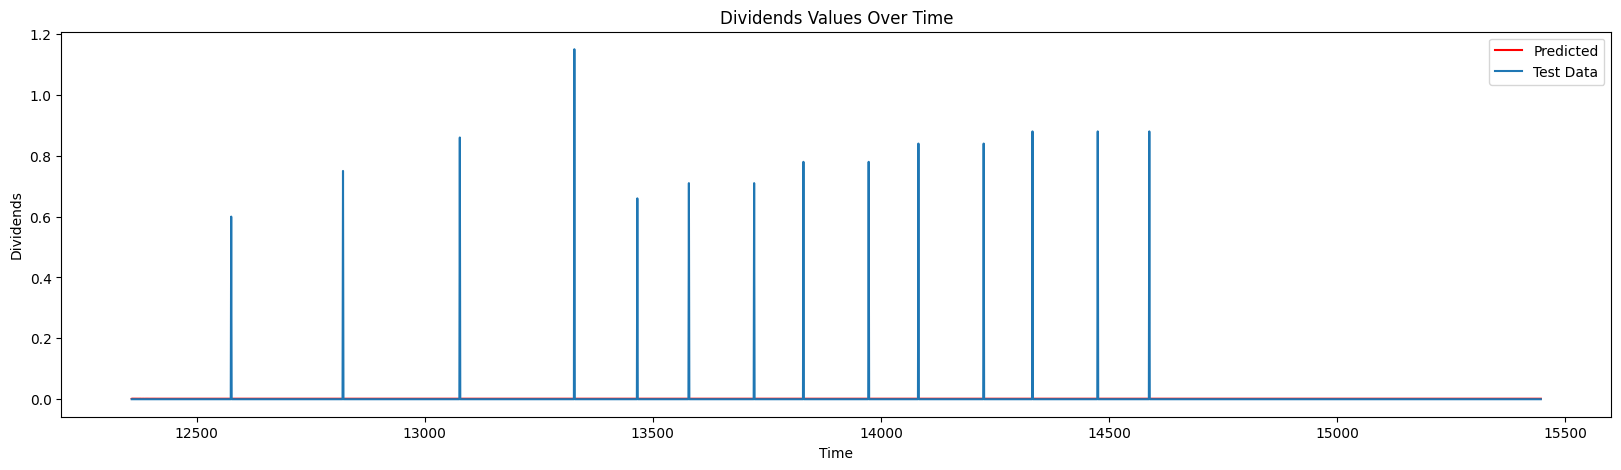

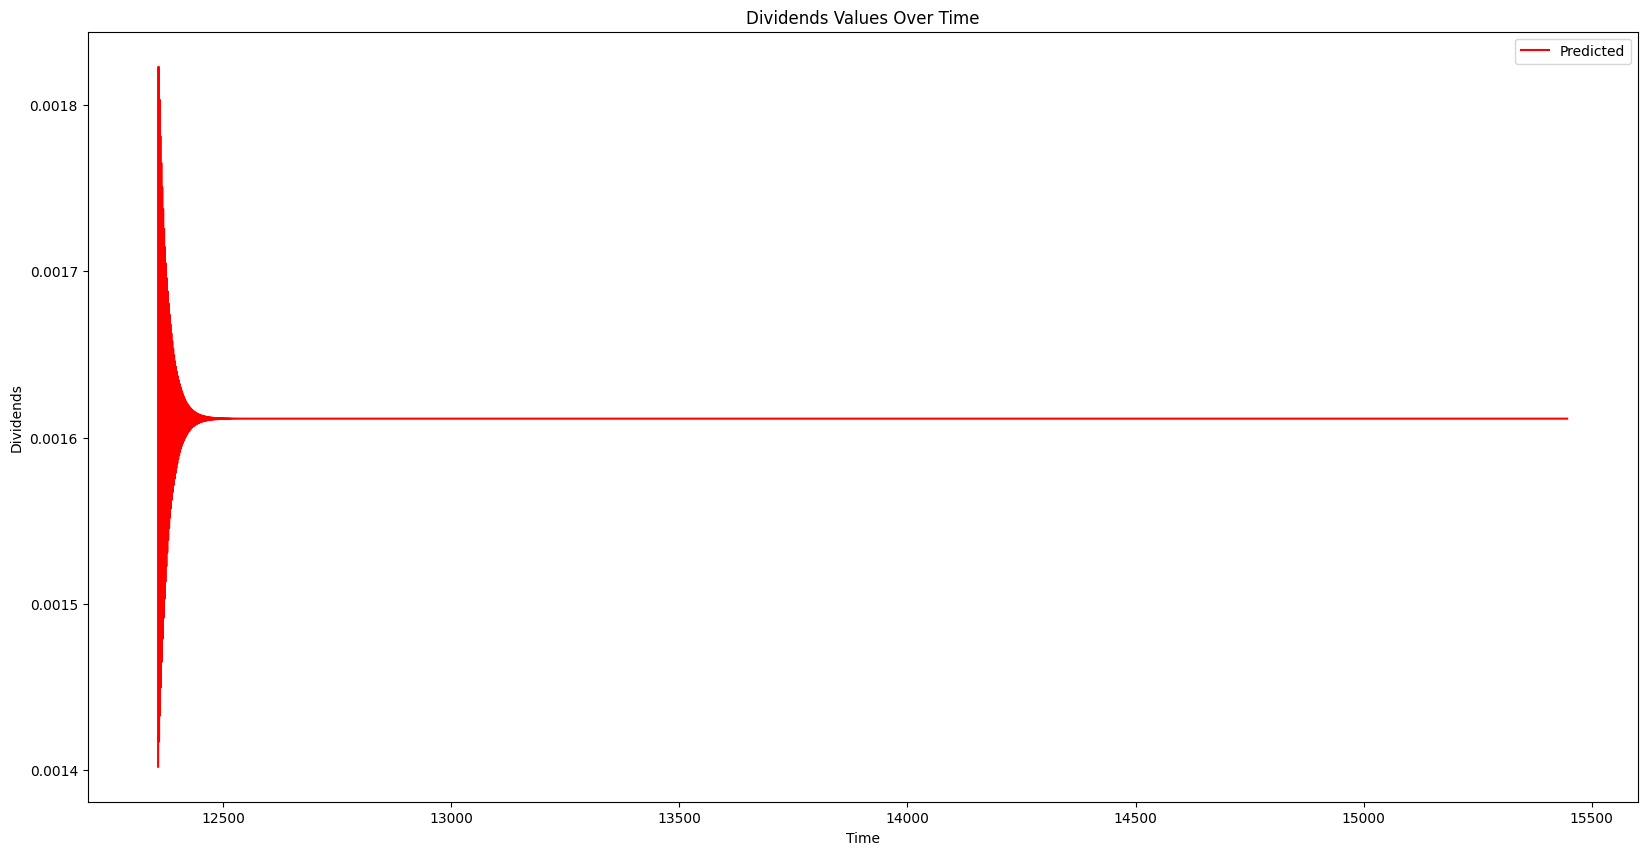

Stock Splits
(0, 0, 0)
(0, 0, 0, 4)


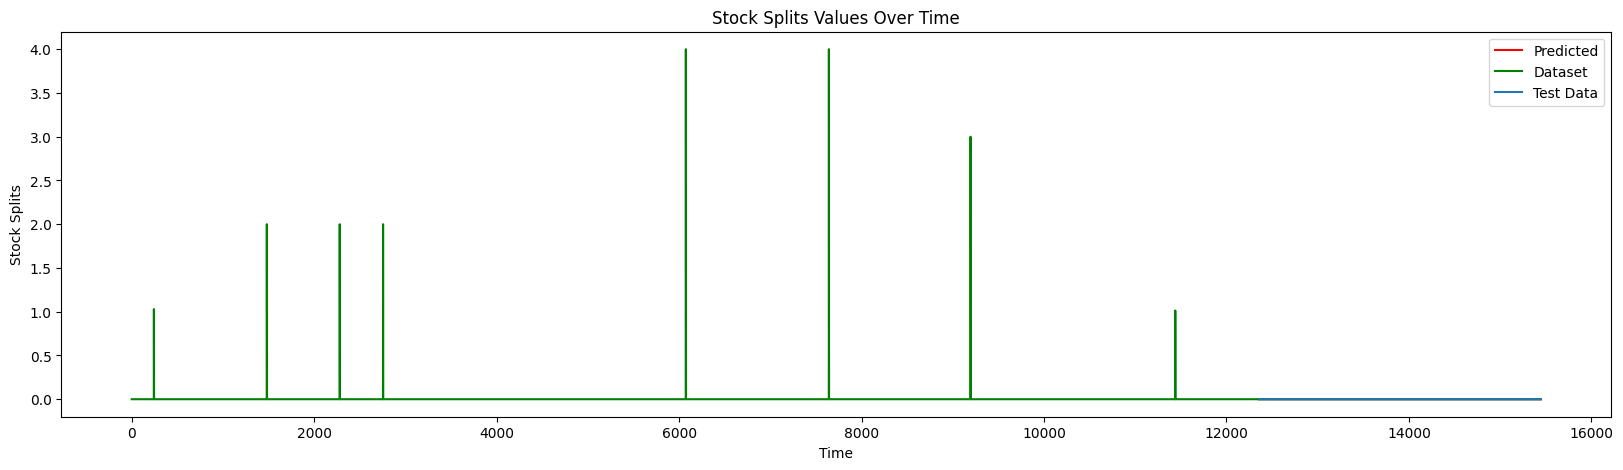

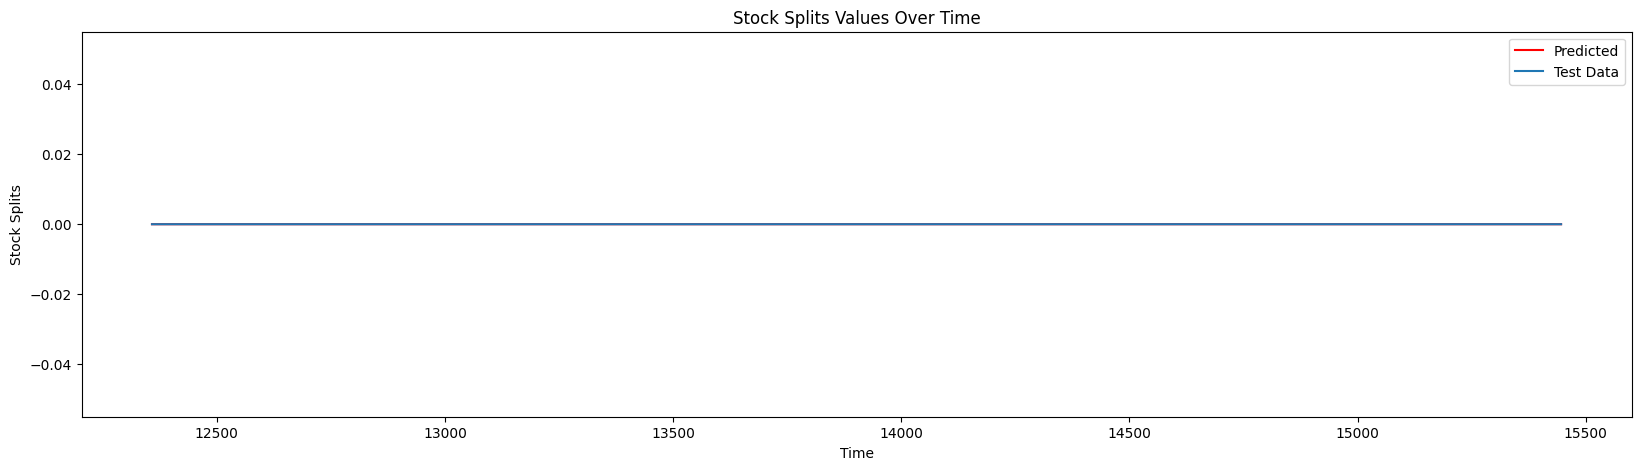

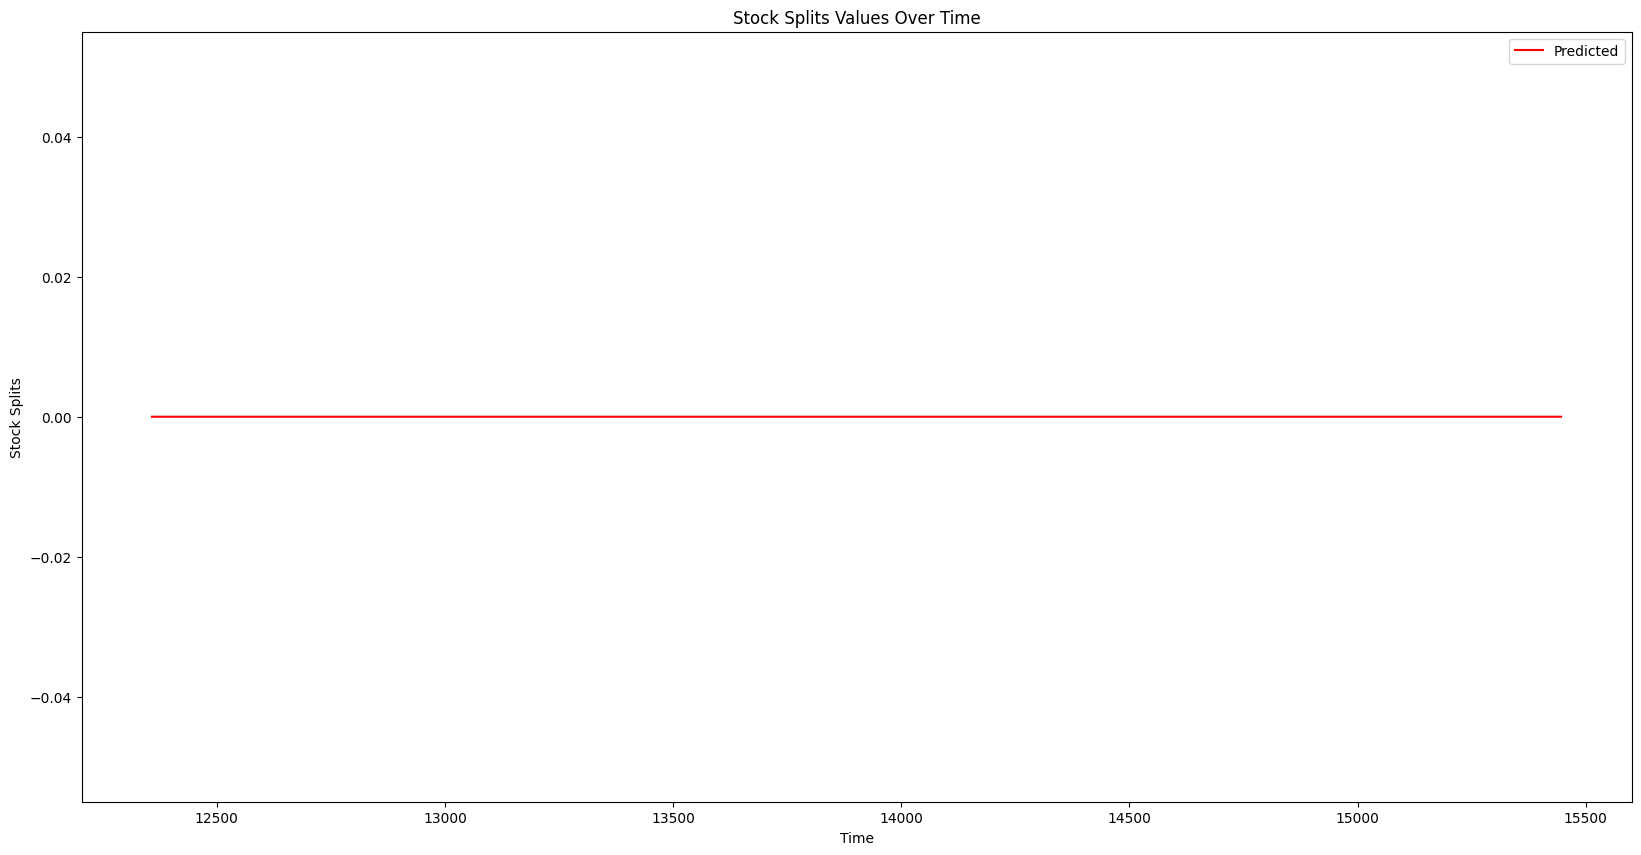

In [10]:
# Create list to store the evaluation
prediction_eval = pd.DataFrame(columns = ["MAE", "MAPE", "MSE", "RMSE"])

# Find the arima p, d, q, P, D, Q values
for values in attribute_list:
    # Find the D value
    D_val = nsdiffs(dataset[values], m = seasonality)

    # Develop the model
    model = auto_arima(dataset[values], 
                       error_action = 'ignore', 
                       suppress_warnings = True, 
#                       max_P = maximum_value,
#                       max_Q = maximum_value,
                       D = D_val,
                       seasonal = True,
                       m = seasonality)
    params = model.get_params()
    params_o = params.get('order')
    params_so = params.get('seasonal_order')
    print(values)
    print(params_o)
    print(params_so)

    # Fit ARIMA model
    sarimax_model = SARIMAX(train_data[values], 
                            order = (params_o[0], params_o[1], params_o[2]), 
                            seasonal_order = (params_so[0], params_so[1], params_so[2], params_so[3]))
    train_model = sarimax_model.fit()

    # Create a prediction based on the number of items in the test data
    prediction_model = train_model.forecast(steps = len(test_data))

    # Calculate metrics using the evaluations function
    predictions = pd.Series(prediction_model)
    prediction_eval.loc[values] = evaluations(test_data[values], predictions)

    # Display the test data (actual) overlayed with the prediction data and the rest of the dataset
    fig, ax = plt.subplots(figsize = (20,5))
    prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    dataset[values].plot(ax = ax, color = 'g', label = 'Dataset')
    test_data[values].plot(ax = ax, label = 'Test Data')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

    # Display the test data (actual) overlayed with the prediction data
    fig, ax = plt.subplots(figsize = (20,5))
    prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    test_data[values].plot(ax = ax, label = 'Test Data')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

    # Display the prediction data
    fig, ax = plt.subplots(figsize = (20,10))
    prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

<font size="6" color = "Orange">COVID Model Training and Testing</font>

Train And Test The COVID Model

Open
(0, 0, 0)
(0, 0, 0, 4)


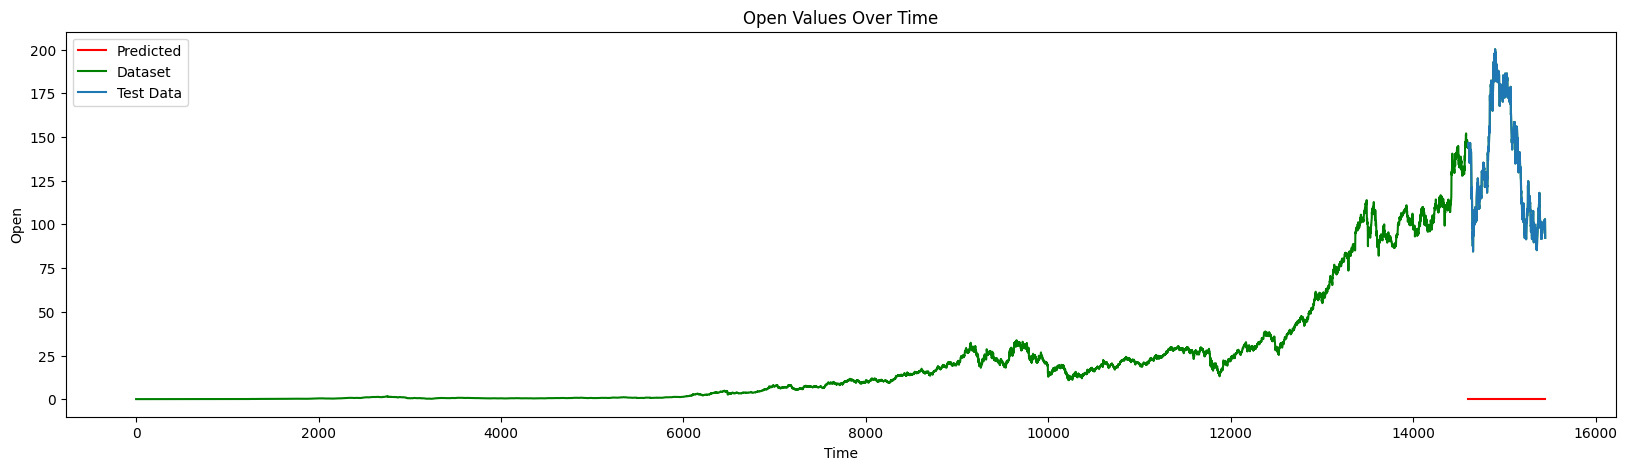

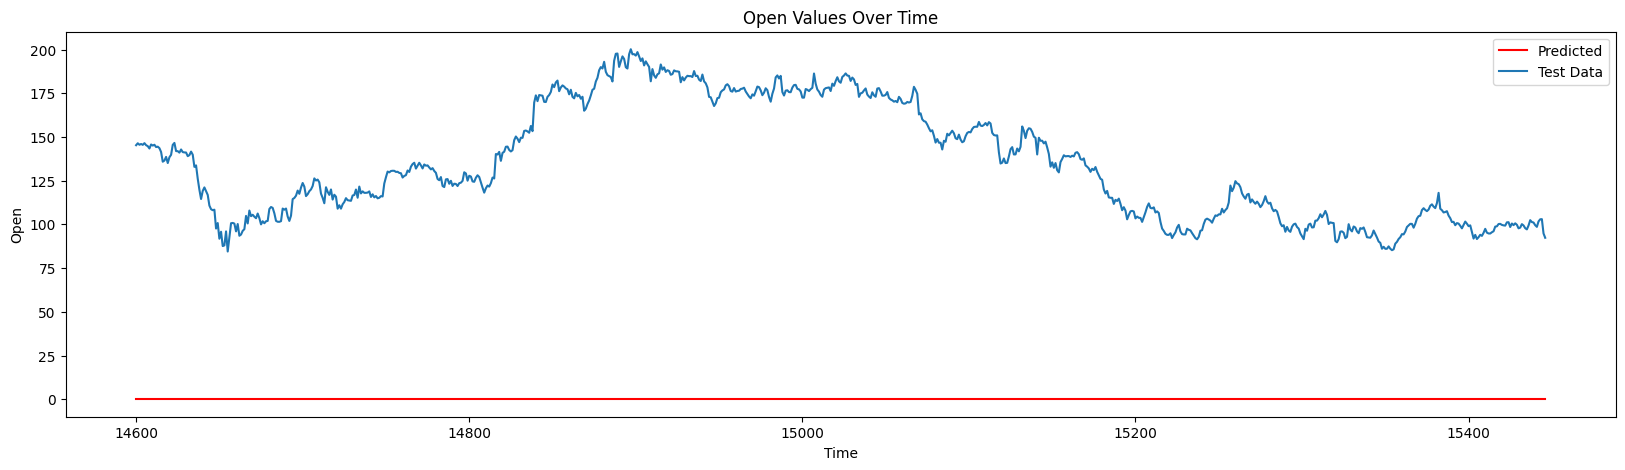

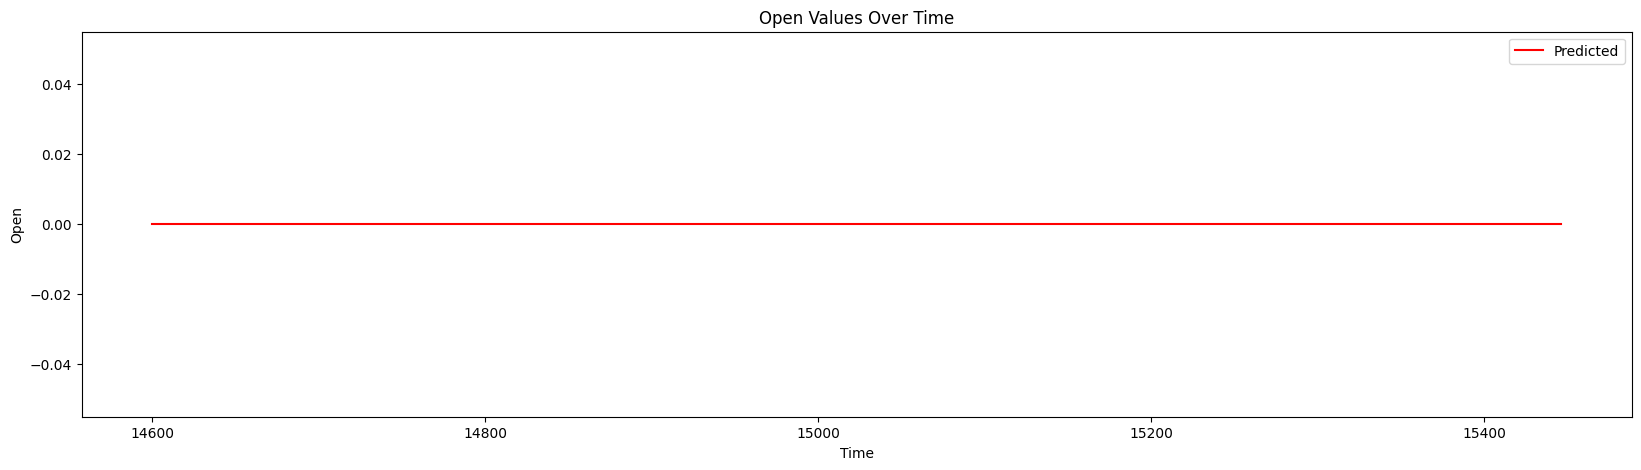

High
(0, 0, 0)
(0, 0, 0, 4)


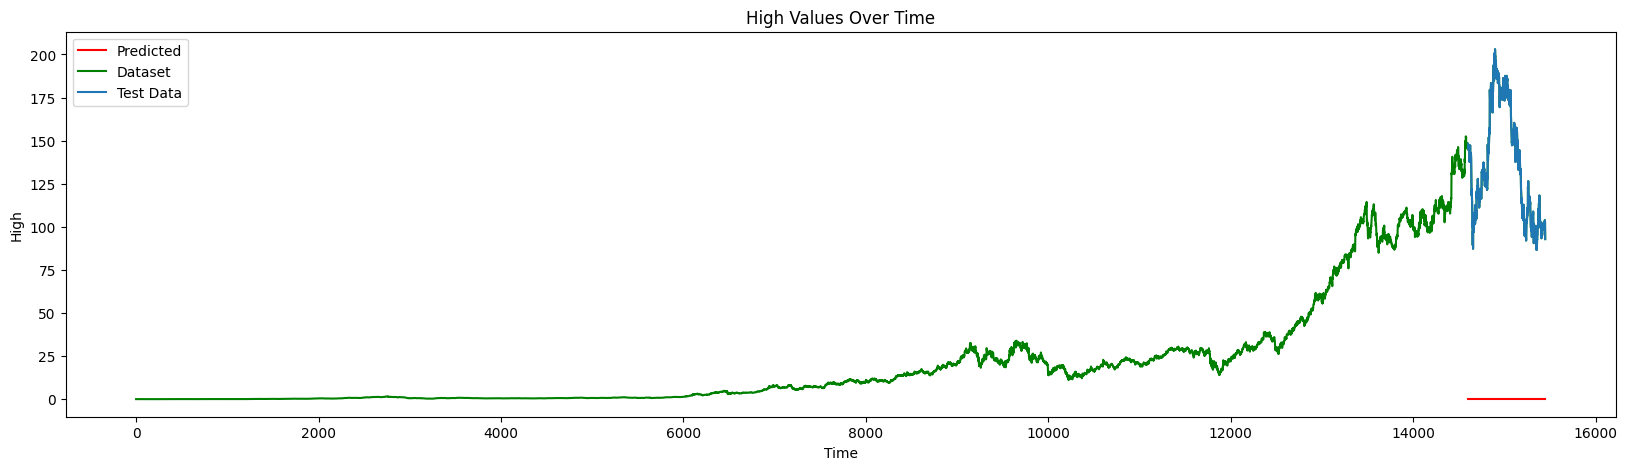

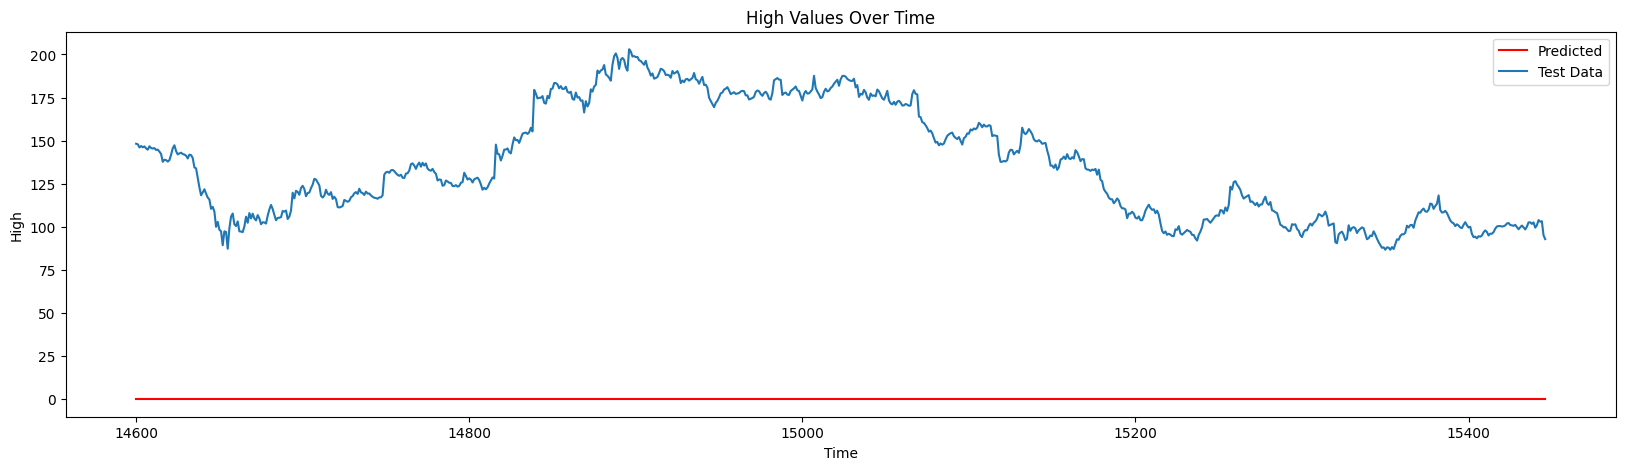

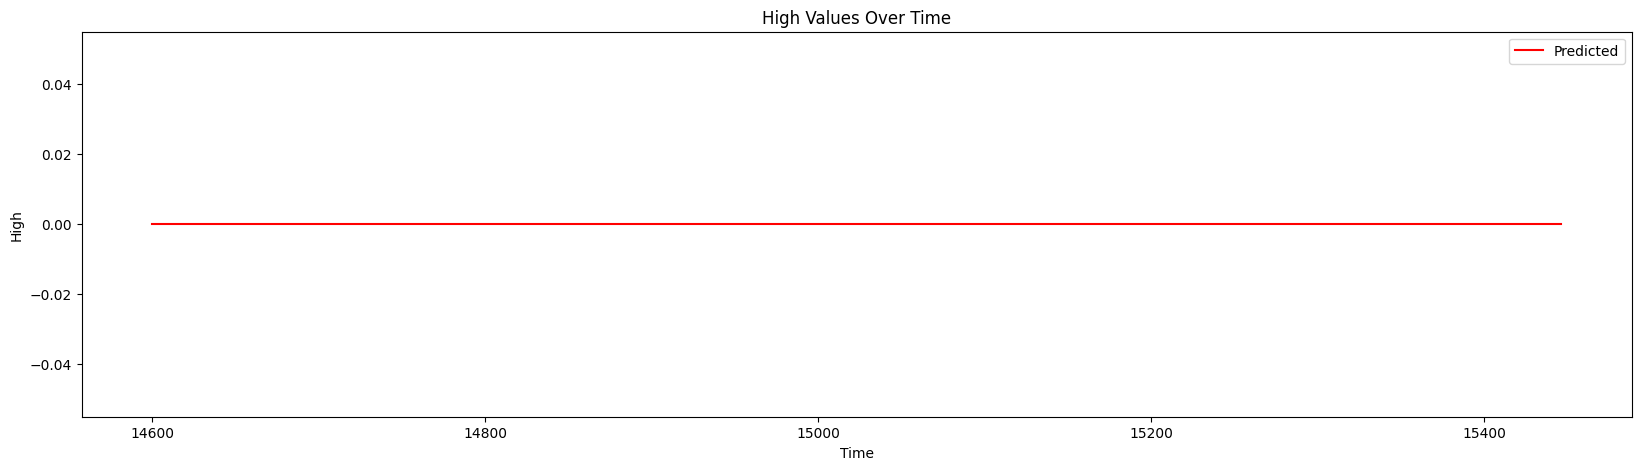

Low
(0, 0, 0)
(0, 0, 0, 4)


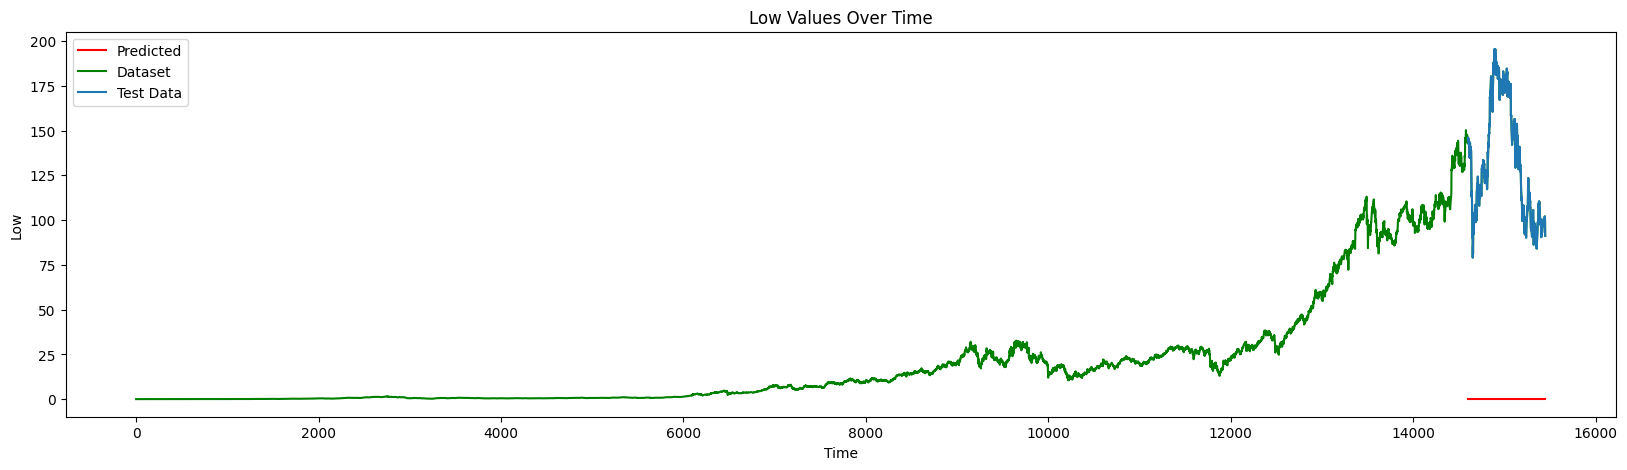

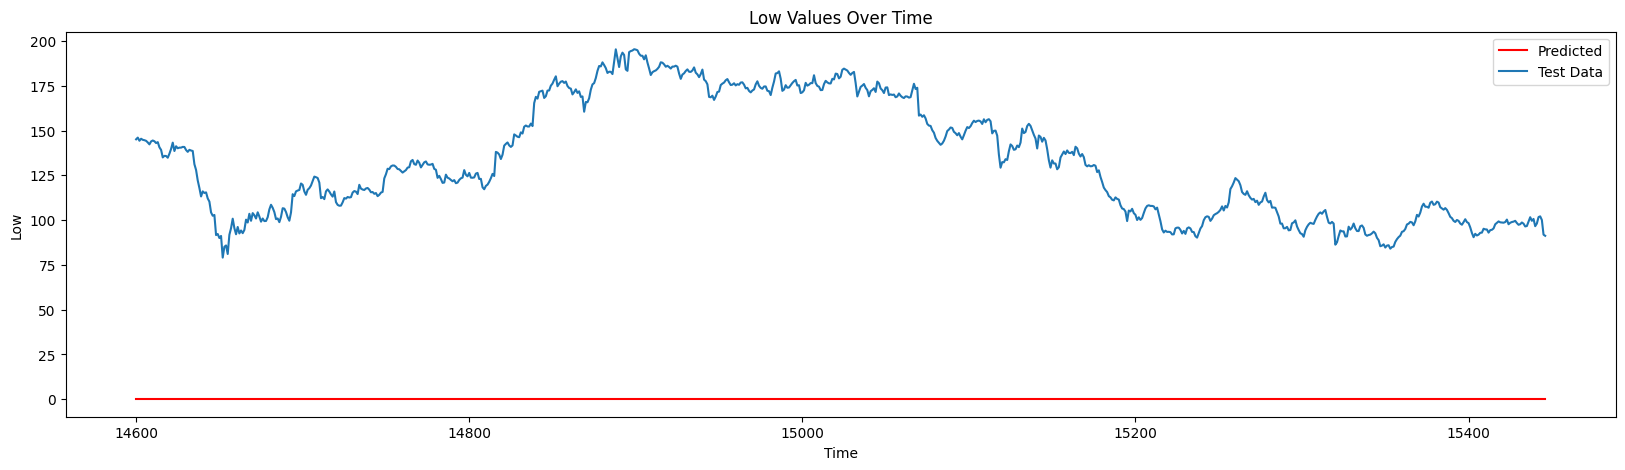

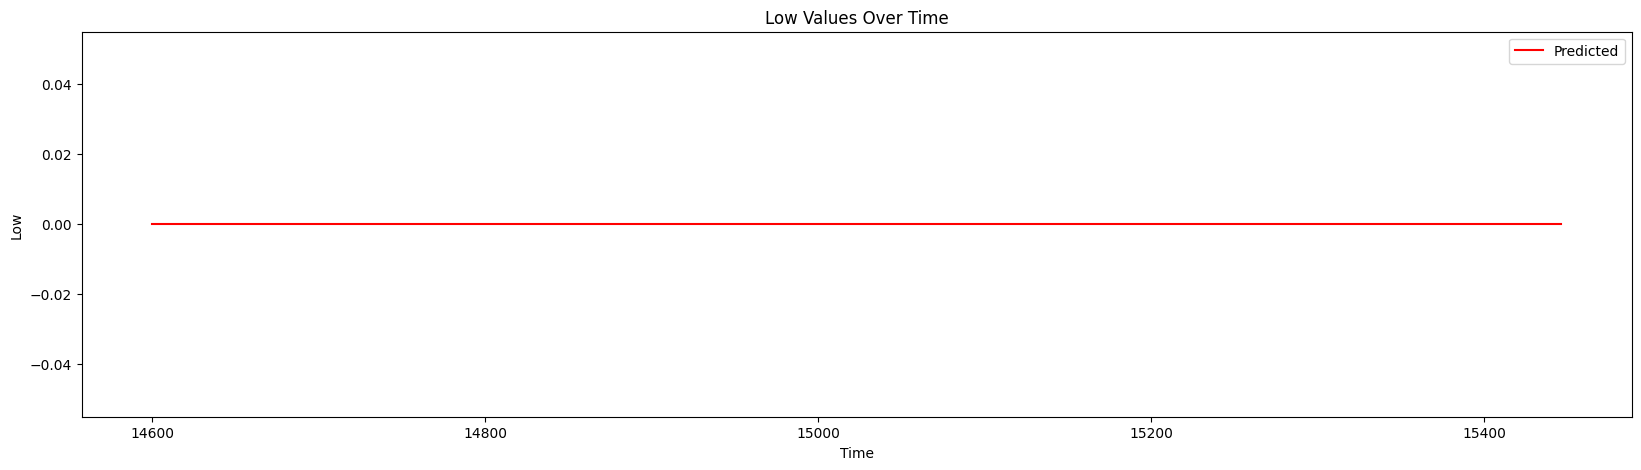

Close
(0, 0, 0)
(0, 0, 0, 4)


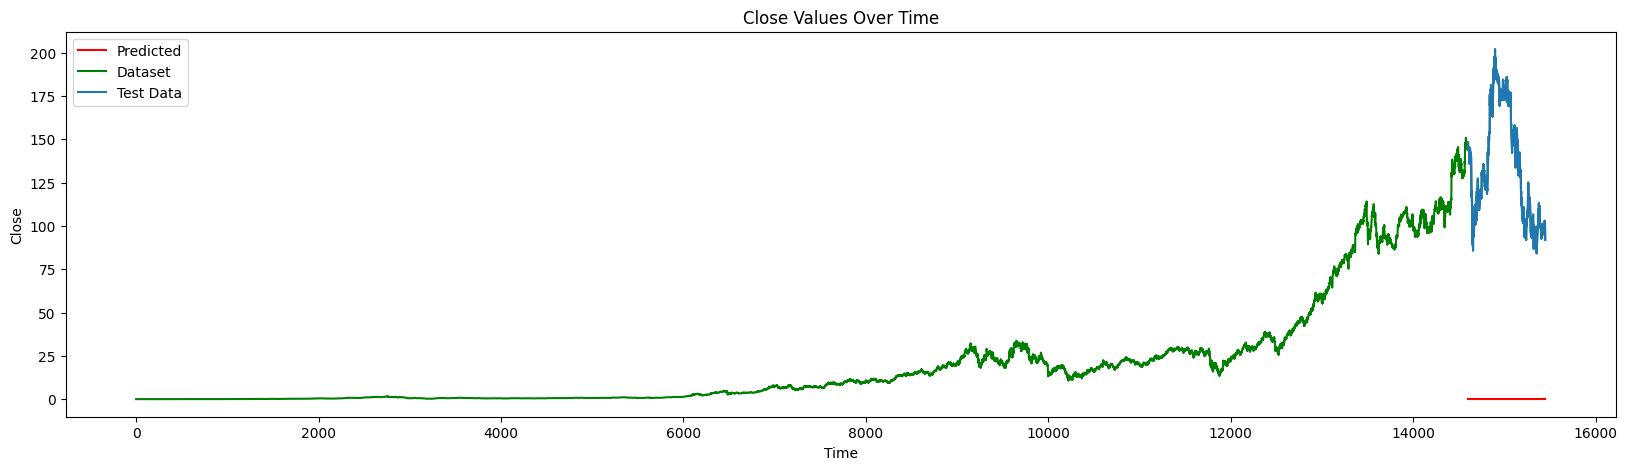

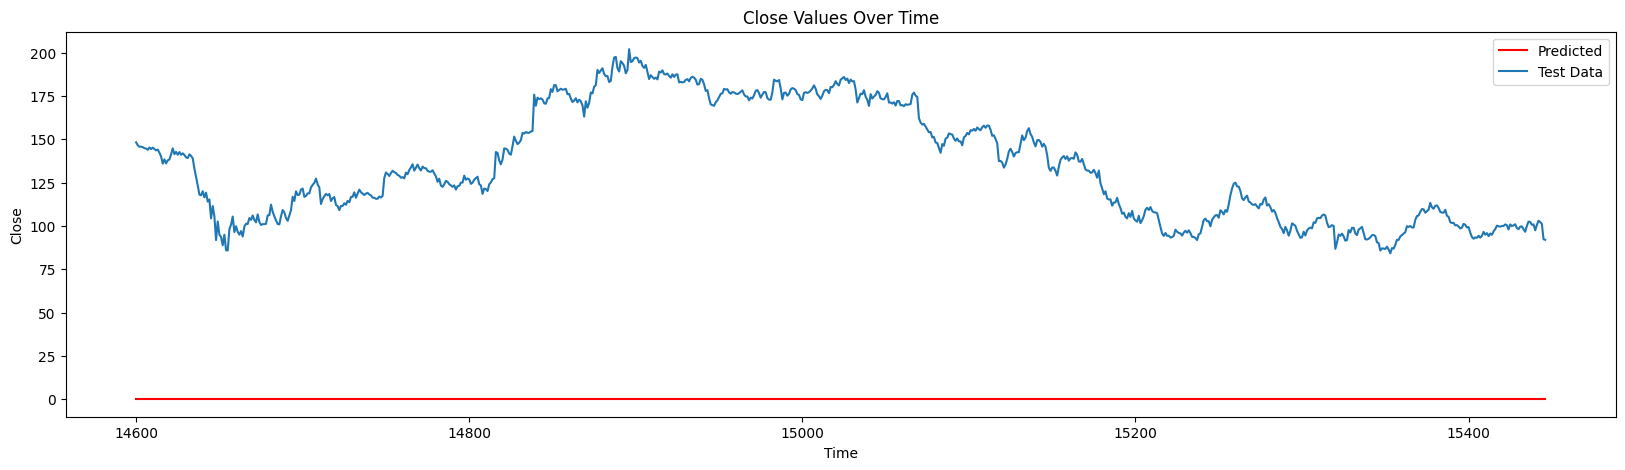

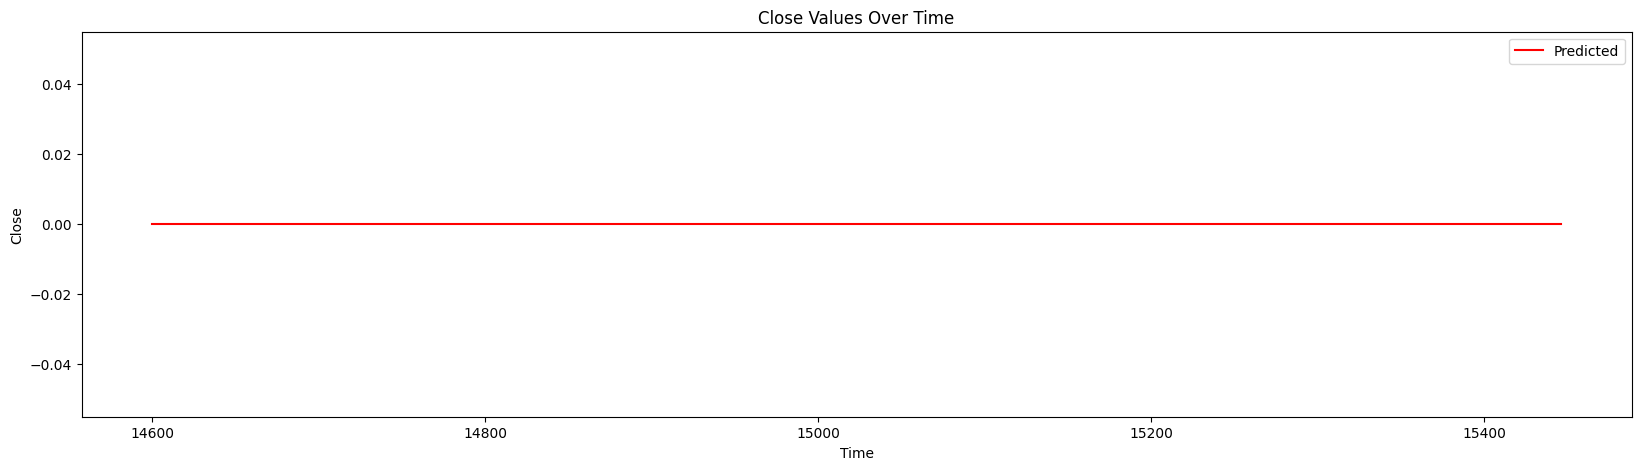

Volume
(0, 0, 0)
(0, 0, 0, 4)


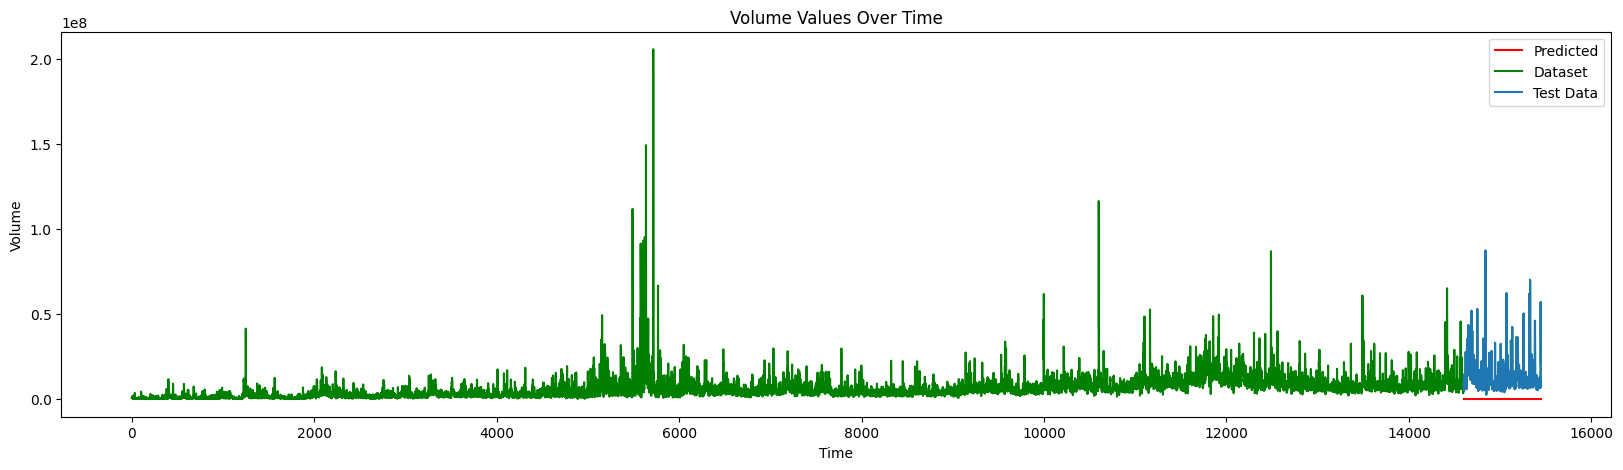

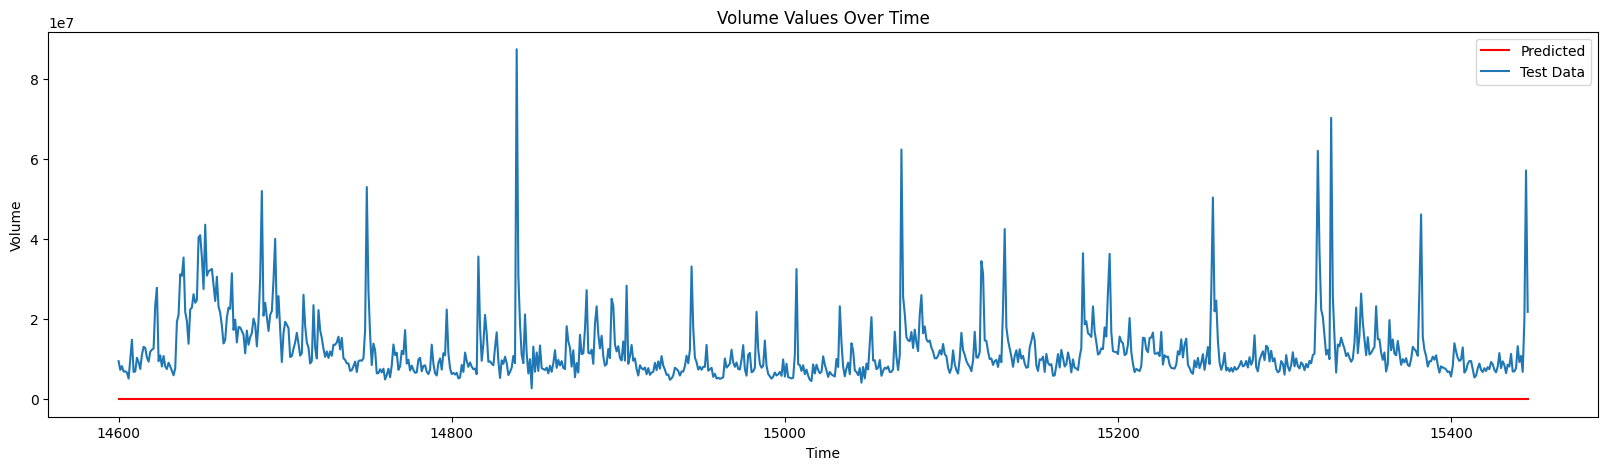

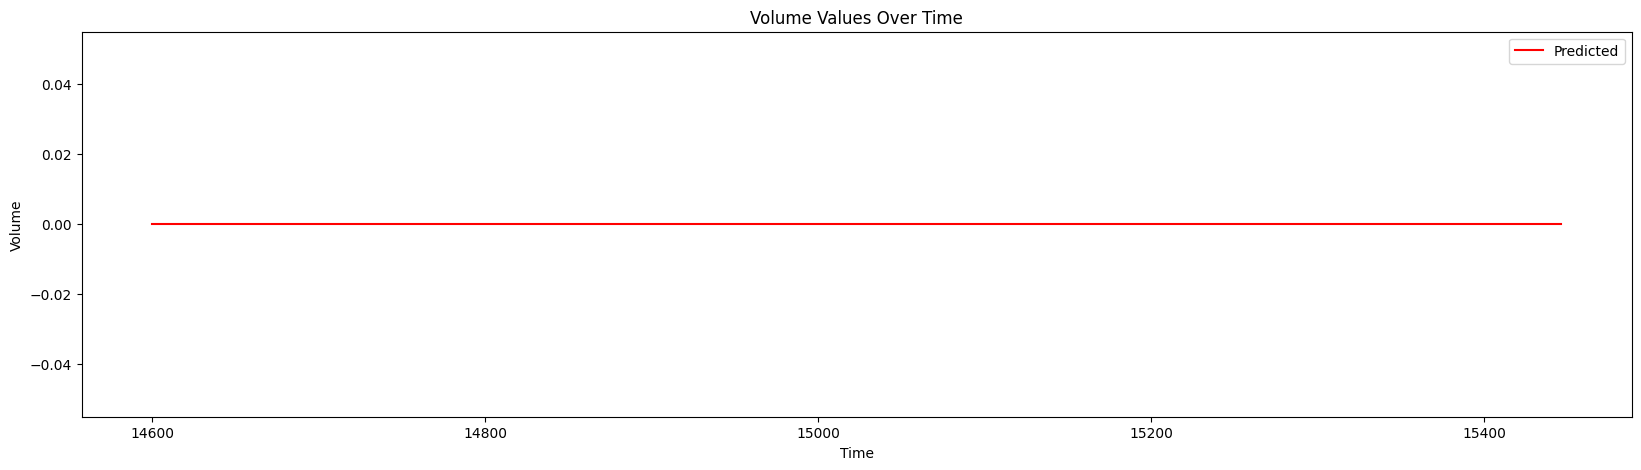

Dividends
(0, 0, 0)
(0, 0, 0, 4)


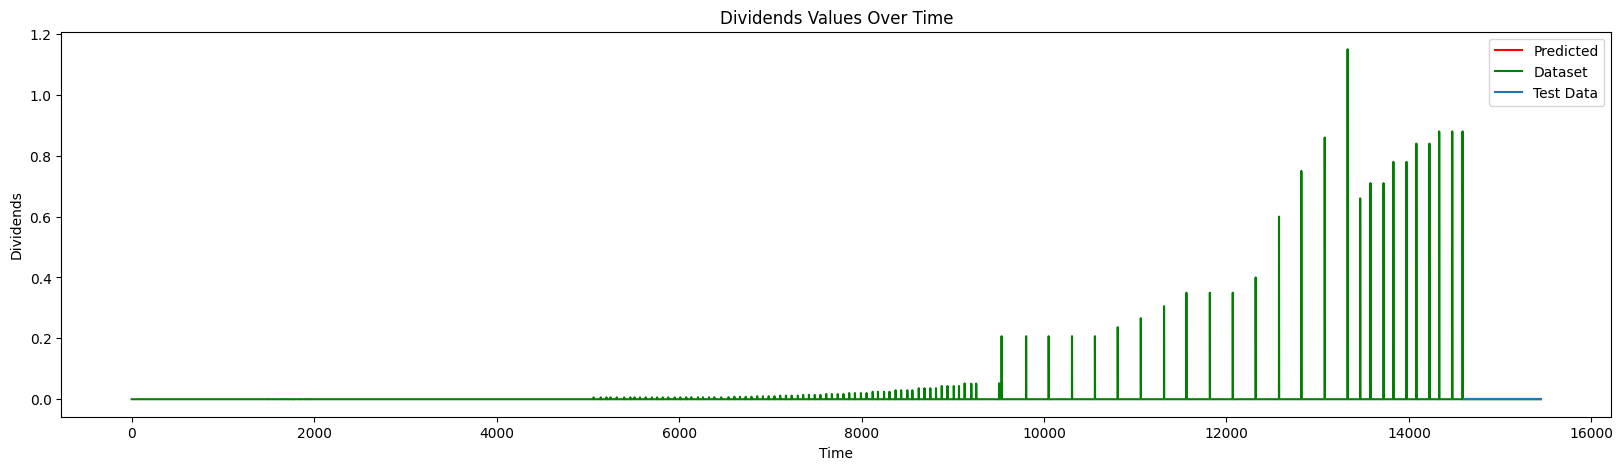

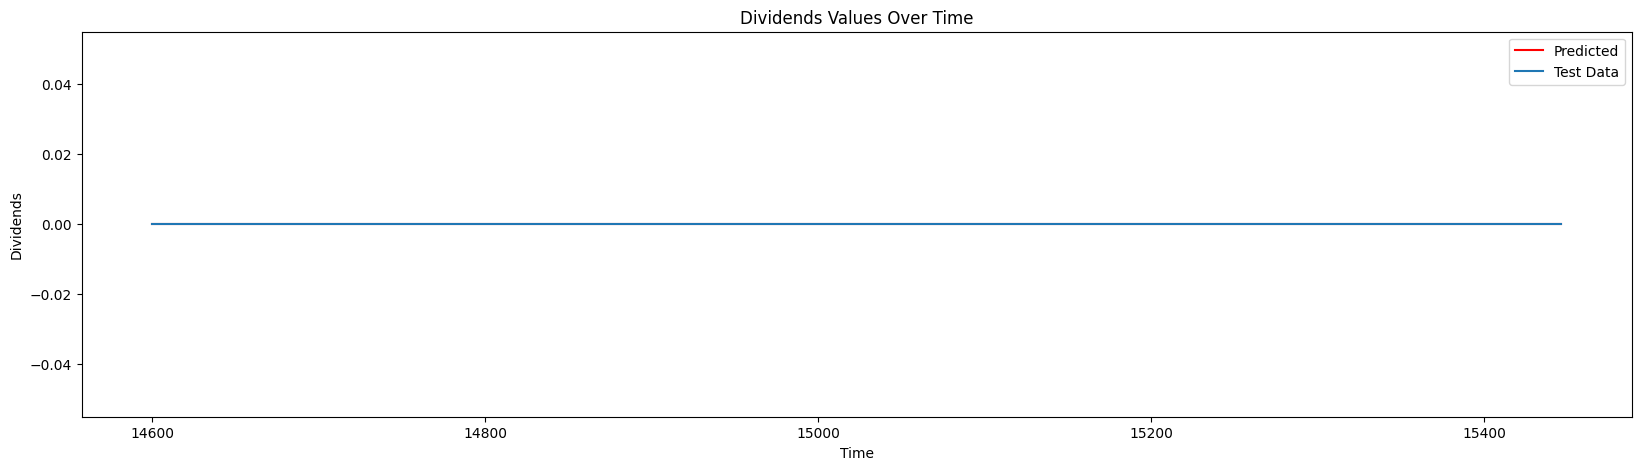

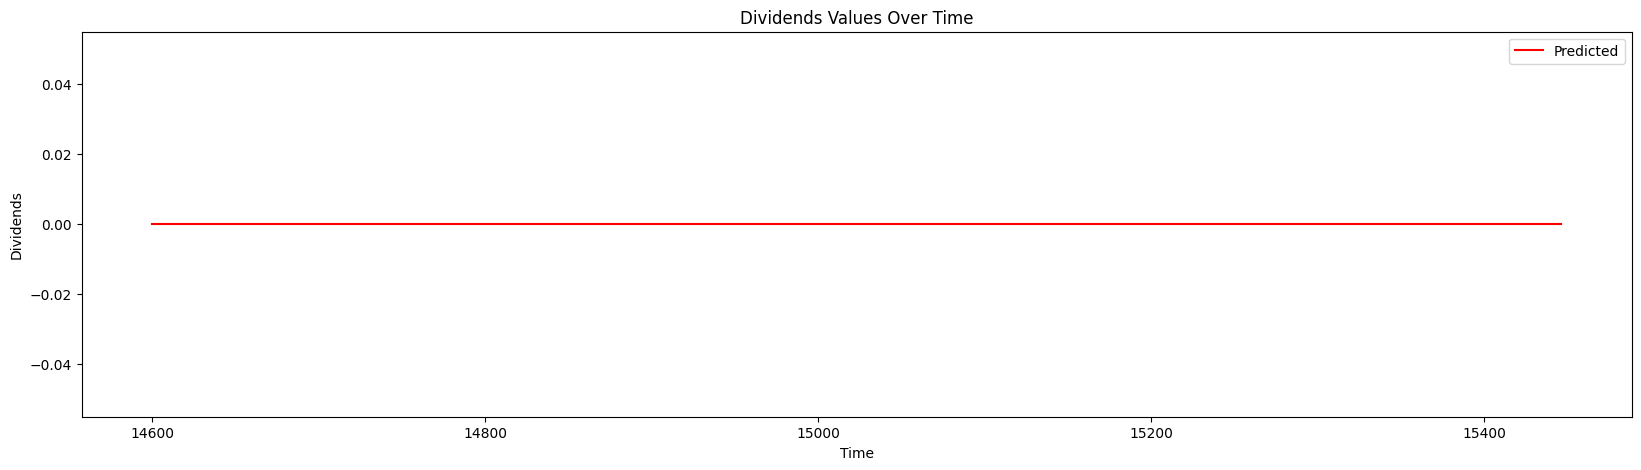

Stock Splits
(0, 0, 0)
(0, 0, 0, 4)


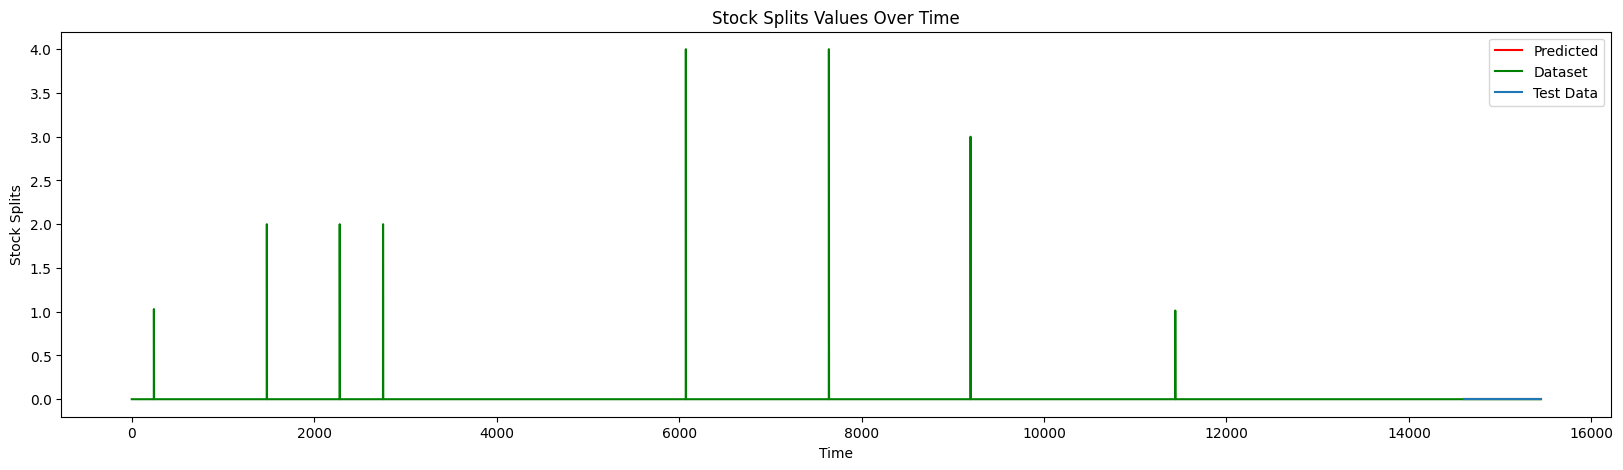

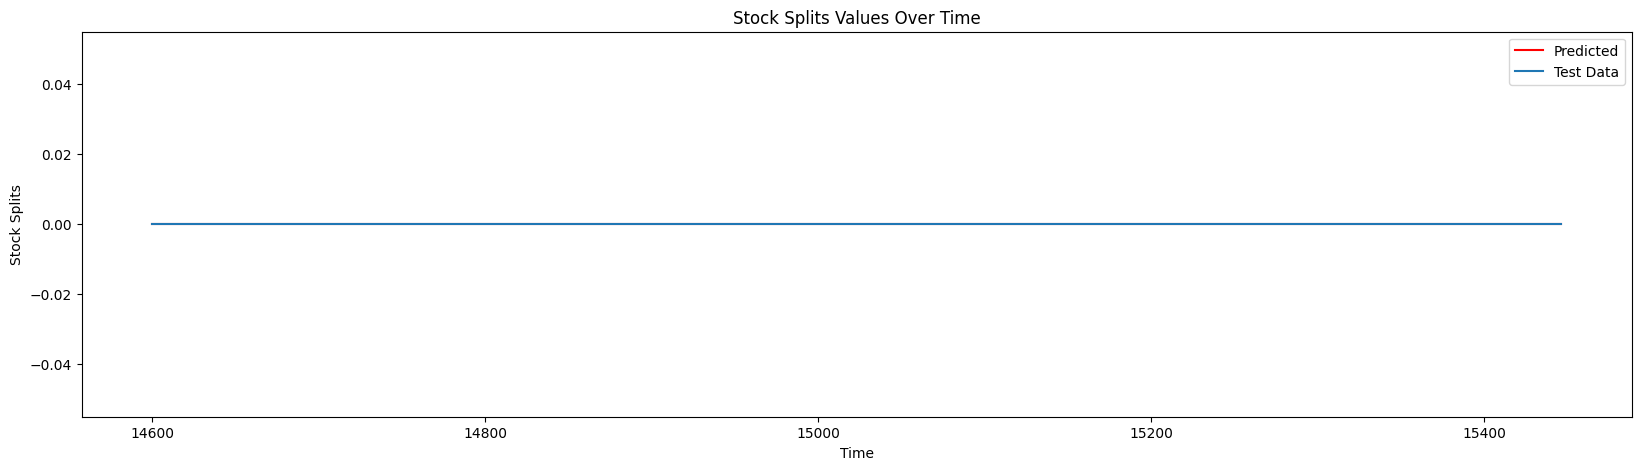

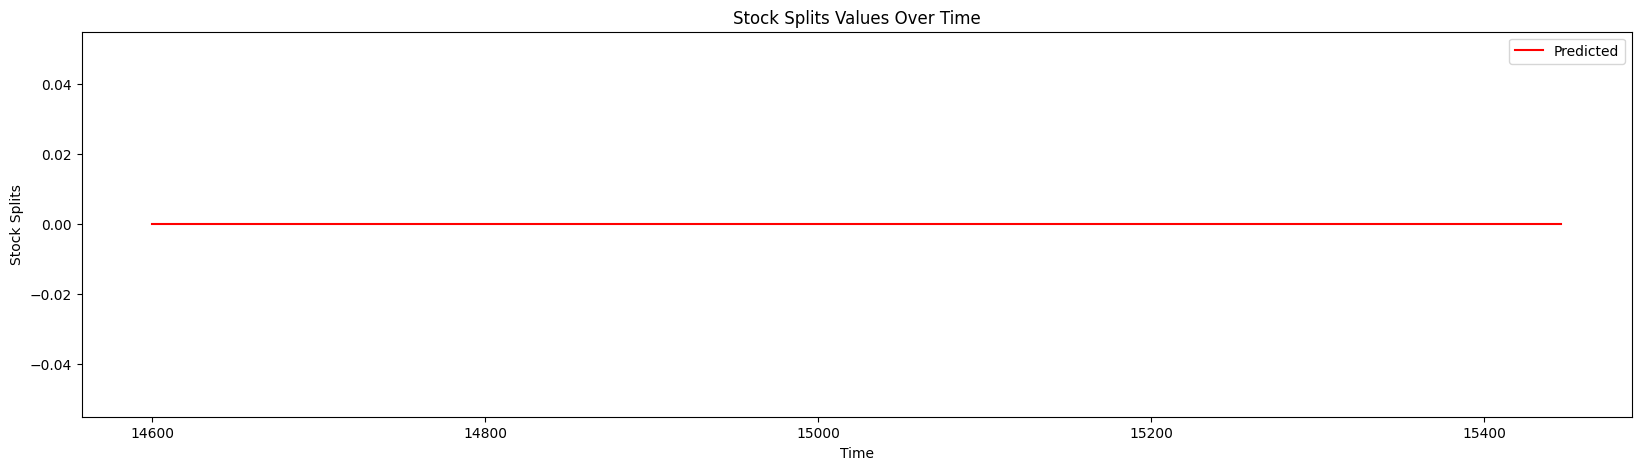

In [11]:
# Create list to store the evaluation
covid_prediction_eval = pd.DataFrame(columns = ["MAE", "MAPE", "MSE", "RMSE"])

# Find the arima p, d, q, P, D, Q values
for values in attribute_list:
    # Find the D value
    D_val = nsdiffs(dataset[values], m = seasonality)

    # Develop the model
    covid_model = auto_arima(dataset[values], 
                       error_action = 'ignore', 
                       suppress_warnings = True, 
#                       max_P = maximum_value,
#                       max_Q = maximum_value,
                       D = D_val,
                       seasonal = True,
                       m = seasonality)
    cov_params = model.get_params()
    cov_params_o = cov_params.get('order')
    cov_params_so = cov_params.get('seasonal_order')
    print(values)
    print(cov_params_o)
    print(cov_params_so)

    # Fit ARIMA model
    covid_model = SARIMAX(covid_train_data[values], 
                            order = (cov_params_o[0], cov_params_o[1], cov_params_o[2]), 
                            seasonal_order = (cov_params_so[0], cov_params_so[1], cov_params_so[2], cov_params_so[3]))
    covid_fitted_model = covid_model.fit()

    # Create a prediction based on the number of items in the test data
    covid_prediction_model = covid_fitted_model.forecast(steps = len(covid_test_data))

    # Calculate metrics using the evaluations function
    covid_predictions = pd.Series(covid_prediction_model)
    covid_prediction_eval.loc[values] = evaluations(covid_test_data[values], covid_predictions)

    # Display the test data (actual) overlayed with the prediction data and the rest of the dataset
    fig, ax = plt.subplots(figsize = (20,5))
    covid_prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    dataset[values].plot(ax = ax, color = 'g', label = 'Dataset')
    covid_test_data[values].plot(ax = ax, label = 'Test Data')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

    # Display the test data (actual) overlayed with the prediction data
    fig, ax = plt.subplots(figsize = (20,5))
    covid_prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    covid_test_data[values].plot(ax = ax, label = 'Test Data')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

    # Display the prediction data
    fig, ax = plt.subplots(figsize = (20,5))
    covid_prediction_model.plot(ax = ax, color = 'r', label = 'Predicted')
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(values)
    plt.title(f"{values} Values Over Time")
    plt.show()

<font size="6" color = "Orange">Model Evaluation</font>

Regular Model Metrics

In [12]:
prediction_eval

,MAE,MAPE,MSE,RMSE
Open,6.241996e+01,5.650083e-01,5.370822e+03,7.328589e+01
High,6.266529e+01,5.615392e-01,5.427558e+03,7.367196e+01
Low,6.160511e+01,5.634605e-01,5.230242e+03,7.232041e+01
Close,6.192179e+01,5.602201e-01,5.297601e+03,7.278462e+01
Volume,3.806304e+06,4.339175e-01,3.936167e+13,6.273888e+06
Dividends,5.261362e-03,7.223995e+12,3.027238e-03,5.502034e-02
Stock Splits,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


Covid Model Metrics

In [13]:
covid_prediction_eval

,MAE,MAPE,MSE,RMSE
Open,1.348978e+02,1.0,1.925074e+04,1.387470e+02
High,1.364459e+02,1.0,1.967768e+04,1.402772e+02
Low,1.331025e+02,1.0,1.876099e+04,1.369708e+02
Close,1.347806e+02,1.0,1.921470e+04,1.386171e+02
Volume,1.236649e+07,1.0,2.178416e+14,1.475946e+07
Dividends,0.000000e+00,0.0,0.000000e+00,0.000000e+00
Stock Splits,0.000000e+00,0.0,0.000000e+00,0.000000e+00
